Old EAZY documentation
http://www.astro.yale.edu/eazy/?doc

In [1]:
%matplotlib inline

In [2]:
import os
import yaml
import pickle
import time

import numpy as np
import matplotlib.pyplot as plt

import astropy.io.fits as pyfits
from astropy.table import Table, join, hstack, vstack

import drizzlepac

import grizli
from grizli.pipeline import photoz
from grizli import utils, prep, multifit, fitting



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
`import jwst` failed so JWST processing will not work!


In [3]:
from grizli_aXe_glw import insidePolygon

In [4]:
from astropy.wcs import WCS

In [5]:
utils.set_warnings()
print('\n Grizli version: ', grizli.__version__)

# Requires eazy-py:  https://github.com/gbrammer/eazy-py
import eazy
print('\n Eazy-py version: ', eazy.__version__)


 Grizli version:  1.6.0.dev43

 Eazy-py version:  0.6.4.dev3+geb2b81b


In [6]:
mJy = 1e-3   # Jy
uJy = 1e-6   # Jy

unit = "uJy"

# erg/s/cm^s/Hz, mJy, microJy, nJy
ab_zps = [48.6, -16.4, -23.9, -31.4]
units  = ["Jy", "mJy", "uJy", "nJy"]

Euclid catalog
    FSpatch_mod3_16183_TAcalib_newGRID_V1.fits
Euclid model spectra
    catalog_11_11.1.spc.fits
SExtractor catalogs

In [7]:
PLINE = {'kernel': 'point', 'pixfrac': 0.6, 'pixscale': 0.3, 'size': 24, 'wcs': None}

def fit_redshift_from_id(id, det, HOME_PATH, root):
    
    mag_limit = 30
    #fwhm = 395 # km/s
    fwhm = 400 # km/s

    group_name = root + "_" + det

    t0 = time.time()

    os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
    with open('Euclid_%s_GrismFLT.pickle' % (det), 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        Euclid = pickle.load(f)

    t1 = time.time()

    print()
    print("Finished in %.1f seconds" % (t1-t0))

    print(Euclid)
    print(Euclid.catalog)
    #beams = OrderedDict()
    print(Euclid.object_dispersers[id])

    T0 = time.time()

    os.chdir(os.path.join(HOME_PATH, root, 'Extractions'))

    # Fitting templates

    # First is set with combined emission line complexes for the redshift fit 
    # (don't allow infinite freedom) of the line ratios / fluxes
    temp0 = grizli.utils.load_templates(
        fwhm=fwhm, 
        line_complexes=True, 
        stars=False,
        full_line_list=None,  
        continuum_list=None,
        fsps_templates=True
    )

    # Second set has individual line templates for fitting the line fluxes
    temp1 = grizli.utils.load_templates(
        fwhm=fwhm, 
        line_complexes=False, 
        stars=False,
        full_line_list=None, 
        continuum_list=None,
        fsps_templates=True
    )

    is_cgs, spectrum_1d, b = Euclid.object_dispersers[id]
    cutout = grizli.model.BeamCutout(Euclid, b['A'], min_sens=0,) # min_mask=0) 

    cutout.beam.compute_model()
    cutout.contam = cutout.beam.cutout_from_full_image(Euclid.model)
    if id in Euclid.object_dispersers:
        cutout.contam -= cutout.beam.model

    hdu = cutout.write_fits(get_hdu=True)
    ext = 0
    hdu[ext].header['EXPTIME'] = hdu['SCI'].header['EXPTIME']

    beam = 'beam_%05d.grism.A.fits' % (id)
    hdu.writeto(beam,overwrite=True)

    mb = multifit.MultiBeam(
        [beam], 
        fcontam=0.2, 
        group_name=group_name, 
        psf=False, 
        min_sens=0.05
    )
    mb.write_master_fits()

    # kludge
    os.remove(beam)
    ###########################
    
    fitting.run_all(
        id, 
        temp0, 
        temp1, 
        fit_only_beams=True, 
        fwhm=fwhm, 
        zr=[0.05, 3.0],
        dz=[0.004, 0.0002], 
        fitter=['nnls', 'bounded'], 
        group_name=group_name,
        pline=PLINE,
    )

    T1 = time.time()

    print()
    print("Finished in %.1f seconds" % (T1-T0))
    
    return mb


In [8]:
def load_phot_from_id(id, det, HOME_PATH, root):

    #id = 1496
    #det = 'DET13'
    #HOME_PATH = "/Users/gwalth/data/Roman/grizli/sims/Euclid"
    #root = "FSpatch_mod3_16183_TAcalib_V1_R_newGRID_2024-05-17"

    #fit_redshift_from_id(id, det, HOME_PATH, root)
    ############################
    ## This isn't necessary for general fitting, but 
    ## load the grism spectrum here for demonstrating the grism/photometry scaling
    group_name = root + "_" + det

    beams_file = '{0}_{1:05d}.beams.fits'.format(group_name, id)

    mb = multifit.MultiBeam(
        beams_file, 
        MW_EBV=0.0,
        fcontam=0.2, 
        #sys_err=args['sys_err'],                       
        group_name=group_name,
    )
    ################################

    # Generate the `phot` dictionary
    phot, ii, dd = phot_obj.get_phot_dict(mb.ra, mb.dec)
    label = "Catalog ID: {0}, dr={1:.2f}, zphot={2:.3f}"
    print(label.format(ez.cat['id'][ii], dd, ez.zbest[ii]))

    print('\n`phot` keys:', list(phot.keys()))
    for k in phot:
        print('\n'+k+':\n', phot[k])

    # Initialize photometry for the MultiBeam object
    mb.set_photometry(**phot)

    ###############################
    # parametric template fit to get reasonable background
    sfit = mb.template_at_z(templates=tspline, fit_background=True, 
                            include_photometry=False)
    fig = mb.oned_figure(tfit=sfit)

    ax = fig.axes[0]
    ax.errorbar(mb.photom_pivot/1.e4, 
                mb.photom_flam/1.e-19, 
                mb.photom_eflam/1.e-19, 
                marker='s', color='k', alpha=0.4, linestyle='None',
                label='Euclid photometry')

    ax.legend(loc='upper left', fontsize=8)
    ax.set_ylim(-10,90)
    #ax.set_xlim(0.65,2.0)
    ax.set_xlim(1.15,1.95)

    #ax.set_yscale("log")
    #ax.set_ylim(0.0001,1000)
    
    return mb


In [9]:
def load_phot_model_from_id(id, det, HOME_PATH, root, model_spectra_file):

    #id = 1496
    #det = 'DET13'
    #HOME_PATH = "/Users/gwalth/data/Roman/grizli/sims/Euclid"
    #root = "FSpatch_mod3_16183_TAcalib_V1_R_newGRID_2024-05-17"

    #fit_redshift_from_id(id, det, HOME_PATH, root)
    ############################
    ## This isn't necessary for general fitting, but 
    ## load the grism spectrum here for demonstrating the grism/photometry scaling
    group_name = root + "_" + det

    beams_file = '{0}_{1:05d}.beams.fits'.format(group_name, id)
    


    mb = multifit.MultiBeam(
        beams_file, 
        MW_EBV=0.0,
        fcontam=0.2, 
        #sys_err=args['sys_err'],                       
        group_name=group_name,
    )
    ################################

    # Generate the `phot` dictionary
    phot, ii, dd = phot_obj.get_phot_dict(mb.ra, mb.dec)
    label = "Catalog ID: {0}, dr={1:.2f}, zphot={2:.3f}"
    print(label.format(ez.cat['id'][ii], dd, ez.zbest[ii]))

    print('\n`phot` keys:', list(phot.keys()))
    for k in phot:
        print('\n'+k+':\n', phot[k])

    # Initialize photometry for the MultiBeam object
    mb.set_photometry(**phot)

    ###############################
    # parametric template fit to get reasonable background
    sfit = mb.template_at_z(templates=tspline, fit_background=True, 
                            include_photometry=False)
    
    fig = mb.oned_figure(tfit=sfit)

    ax = fig.axes[0]
    ax.errorbar(mb.photom_pivot/1.e4, 
                mb.photom_flam/1.e-19, 
                mb.photom_eflam/1.e-19, 
                marker='s', color='k', alpha=0.4, linestyle='None',
                label='Euclid photometry')
    
    ids = load_spectra_ids(model_spectra_file)
    ind = ids.index(ez.cat['id'][ii])+1
    model_wav, model_flux = load_spectrum_from_id(ind, model_spectra_file)
    
    ax.plot(model_wav/1.e4, model_flux/1.e-19, label='Model spectrum')

    ax.legend(loc='upper left', fontsize=8)
    ax.set_ylim(-10,90)
    #ax.set_xlim(0.65,2.0)
    ax.set_xlim(1.15,1.95)

    #ax.set_yscale("log")
    #ax.set_ylim(0.0001,1000)
    
    return mb


In [10]:
#euclid_sims_path = "/Users/gwalth/data/Roman/grizli/sims/Euclid/Raw/EuclidSIMS/"
#root = "FSpatch_mod3_16183_TAcalib_V1_R_newGRID_2024-05-17"

def euclid_model_spectra_prep(det_num, frame, euclid_sims_path, root):
    model_spectra_path = "%s/frame%i/Input_Spectra/" % (root, frame)
    model_spectra = "catalog_%s_%s.%i.spc.fits" % (det_num, det_num, frame)
    model_spectra_file = os.path.join(euclid_sims_path, model_spectra_path, model_spectra)
    
    return model_spectra_file

def load_spectra_ids(model_spectra_file):
    t0 = time.time()

    with pyfits.open(model_spectra_file) as hdul:                 # 28 seconds
    #with pyfits.open(model_spectra, memmap=False) as hdul:
    #with pyfits.open(model_spectra, memmap=True) as hdul:
        N = len(hdul)
        #print(N)
        #print(hdul[0].header)
        #print(hdul[1].header)
        #print(hdul[1].columns)

        ids = [hdul[i].header['ID'] for i in range(1,N)]
    #print(ids)

    t1 = time.time()
    print("Time to compute: %.2f s" % (t1-t0))

    return ids

#ids = load_spectra_ids(model_spectra_file)
#ind = ids.index(source_id)+1

def load_spectrum_from_id(ind, model_spectra_file):

    with pyfits.open(model_spectra_file) as hdul:
        print('index =', ind)
        head = hdul[ind].header
        data = hdul[ind].data
        model_wav = data.field('WAV_NM')*10 # Ang
        model_flux = data.field('FLUX') # ? 
        print('ID =', head['ID'])

    return model_wav, model_flux


In [11]:
def load_footprints(slitless):

    footprints = {}

    for single in slitless:
        pf = pyfits.open(single)
        #pf.info()
        head_pri = pf[0].header
        #print(head_pri)
        head_sci = pf[1].header
        #print(head_sci)

        det_id = head_sci['DET_ID']

        wcs = WCS(head_sci)
        footprint = wcs.calc_footprint(header=head_sci)
        footprints[det_id] = footprint

    return footprints

In [12]:
def match_src_det(coords, footprints):
    """Matches a detector to a set of coordinates that are inside the detectors boundaries.
    
    Parameters
    ----------
    coords : list or array
        List or NumPy array of RA, Dec.
    
    footprints: dict
        Dictionary of detectors with their values set to the NumPy array of their footprint
            
    Returns
    -------
    src_det_list : list
        List of detector str.    
    """

    src_det_list = []
    for p0 in coords:

        src_det = None
        for det in footprints:
            A = footprints[det]
            inside = insidePolygon(A, p0)

            if inside: 
                src_det = det
        src_det_list.append(src_det)

    return src_det_list

In [13]:
def match_src_coords(ra_col, dec_col, ra, dec):
    """Match a sources coordinates to an array of coordinates
    
    Paramters
    ---------
    ra_col: array
        Array of RA coordinates [deg]
    
    dec_col: array
        Array of Dec coordinate [deg]
    
    ra: float
        RA coordinates of source [deg]
    
    dec: float
        Dec coordinates of source [deg]
    
    Returns
    -------
    ind: int
        Index of matching coordinates
    
    dr: float
        Distance of the matching coordinates [arcsec]
    
    """
    dr = np.sqrt((ra_col-ra)**2*np.cos(dec/180*np.pi)**2 +
        (dec_col-dec)**2)*3600.
    
    ind = np.argmin(dr)
    
    return ind, dr

In [14]:
HOME_PATH = '/Users/gwalth/data/Roman/grizli/sims/Euclid/'
print('HOME_PATH = ', HOME_PATH)
root = 'FSpatch_mod3_16183_TAcalib_V1_R_newGRID_2024-05-17'

yaml_file = os.path.join(HOME_PATH, root, "config.yaml")
print(yaml_file)

HOME_PATH =  /Users/gwalth/data/Roman/grizli/sims/Euclid/
/Users/gwalth/data/Roman/grizli/sims/Euclid/FSpatch_mod3_16183_TAcalib_V1_R_newGRID_2024-05-17/config.yaml


In [15]:
# Load the yaml file for the current reduction

#YAML_PATH = os.getcwd()
with open(yaml_file, 'r') as f:
    yaml_dict = yaml.safe_load(f)
    print(yaml_dict)
    print(yaml_dict.keys())

#HOME_PATH = yaml_dict["HOME_PATH"]
#print("HOME_PATH =", HOME_PATH)
#root = yaml_dict["root"]
#print("root =", root)
YAML_PATH = os.path.join(HOME_PATH, root)

all_final_slitless = yaml_dict["all_final_slitless"]
catalog = yaml_dict["catalog_files"][0]

{'HOME_PATH': '/Users/gwalth/data/Roman/grizli/sims/Euclid', 'root': 'FSpatch_mod3_16183_TAcalib_V1_R_newGRID_2024-05-17', 'slitless_files': ['NISP_SLITLESS_FRAME1_FSpatch_mod3_16183_TAcalib_V1_R_newGRID_2024-05-17.fits'], 'thumbnail_files': ['Input_Thumbnails_frame1', 'Input_Thumbnails_frame2', 'Input_Thumbnails_frame3', 'Input_Thumbnails_frame4'], 'catalog_files': ['FSpatch_mod3_16183_TAcalib_newGRID_V1.fits'], 'ref_files': ['Euclid-VIS_ref.fits', 'Euclid-NISP_Y_ref.fits', 'Euclid-NISP_J_ref.fits', 'Euclid-NISP_H_ref.fits'], 'mag_zero': [25.6, 25.04, 25.26, 25.21, 26.0], 'nexp': 4, 'all_ref_files': ['Euclid-VIS_ref.fits', 'Euclid-NISP_Y_ref.fits', 'Euclid-NISP_J_ref.fits', 'Euclid-NISP_H_ref.fits', 'Euclid-total_ref.fits'], 'all_cat': ['Euclid-VIS_ref.cat', 'Euclid-NISP_Y_ref.cat', 'Euclid-NISP_J_ref.cat', 'Euclid-NISP_H_ref.cat', 'Euclid-total_ref.cat'], 'all_seg': ['Euclid-VIS_ref_seg.fits', 'Euclid-NISP_Y_ref_seg.fits', 'Euclid-NISP_J_ref_seg.fits', 'Euclid-NISP_H_ref_seg.fits', '

In [16]:
os.chdir('{0}/{1}/Prep/'.format(HOME_PATH, root))

In [ ]:
# prepare catalog for EAZY photometry fitting

In [17]:
tbl = Table.read(catalog, format='fits')
print(tbl)
print(tbl.keys())

Euclid_bands_flux = ['TU_FNU_VIS_MAG', 'TU_FNU_Y_NISP_MAG', 'TU_FNU_J_NISP_MAG', 'TU_FNU_H_NISP_MAG']
Euclid_bands_mag = ["VIS", "NIR_Y", "NIR_J", "NIR_H"]
all_keys = ["SOURCE_ID", "RA_MAG", "DEC_MAG", 'Z_OBS'] + Euclid_bands_flux

new_tbl = tbl[all_keys].copy()

print(tbl[Euclid_bands_flux])
print(tbl[Euclid_bands_mag])

SOURCE_ID    HALO_ID    KIND ...  metal   SPECTRA_HDU SED_INDEX
                             ...                               
--------- ------------- ---- ... -------- ----------- ---------
   760091 3946540868640    0 ... 8.587772           2         0
  2131630 3946540826621    0 ... 8.497727           2         1
   696238 3946550382768    0 ...  8.52077           2         2
  7306139 3844500802491    0 ... 8.586477           2         3
 11525864 3844510284279    0 ... 8.490682           2         4
 10579490 3844500851567    0 ... 8.467874           2         5
      ...           ...  ... ...      ...         ...       ...
 12492321 4047560465979    0 ... 8.407932           2      2489
  1460246 3945520049284    0 ... 8.520879           2      2490
    73525 3946540971212    0 ... 8.584223           2      2491
  6645296 3843500797461    0 ... 8.622855           2      2492
  3953848 3844510884163    0 ... 8.635932           2      2493
 12960857 4047550444598    0 ... 8.51677

In [18]:
for band in Euclid_bands_flux:
    new_band = band.replace("_MAG","_FLUX")
    err_band = band.replace("_MAG","_ERR")
    #new_tbl[new_band] =  tbl[band]/mJy
    #new_tbl[err_band] =  tbl[band]/mJy * 0.05 # 5% error
    new_tbl[new_band] =  tbl[band]/uJy
    new_tbl[err_band] =  tbl[band]/uJy * 0.05 # 5% error
    
# convert to what eazy expects
new_tbl.rename_column('SOURCE_ID', 'id')
new_tbl.rename_column('Z_OBS', 'z_spec')
new_tbl.rename_column('RA_MAG', 'ra')
new_tbl.rename_column('DEC_MAG', 'dec')

In [19]:
print(new_tbl)

   id            ra         ... TU_FNU_H_NISP_FLUX TU_FNU_H_NISP_ERR
                            ...         Jy                 Jy       
-------- ------------------ ... ------------------ -----------------
  760091  213.5326853621862 ...          37.392925         1.8696463
 2131630  213.5327347549859 ...          28.422722         1.4211361
  696238 213.53278414801076 ...          26.976467         1.3488234
 7306139 213.53283354911247 ...           76.71511         3.8357556
11525864 213.53288296614792 ...           29.37089         1.4685445
10579490 213.53293238341146 ...          38.780064         1.9390032
     ...                ... ...                ...               ...
12492321  212.2226323306473 ...          4.2760715        0.21380357
 1460246 212.22258110315803 ...           13.68844          0.684422
   73525 212.22252987521202 ...         14.2946205        0.71473104
 6645296  212.2224786305207 ...          23.235796         1.1617898
 3953848 212.22242738537045 ...   

In [20]:
os.chdir('{0}/{1}/Extractions/'.format(HOME_PATH, root))

In [21]:
new_file = catalog.replace('.fits','_flux.fits')
print(new_file)

FSpatch_mod3_16183_TAcalib_newGRID_V1_flux.fits


In [22]:
new_tbl.write(new_file, overwrite=True)            

In [23]:
print(new_tbl)

   id            ra         ... TU_FNU_H_NISP_FLUX TU_FNU_H_NISP_ERR
                            ...         Jy                 Jy       
-------- ------------------ ... ------------------ -----------------
  760091  213.5326853621862 ...          37.392925         1.8696463
 2131630  213.5327347549859 ...          28.422722         1.4211361
  696238 213.53278414801076 ...          26.976467         1.3488234
 7306139 213.53283354911247 ...           76.71511         3.8357556
11525864 213.53288296614792 ...           29.37089         1.4685445
10579490 213.53293238341146 ...          38.780064         1.9390032
     ...                ... ...                ...               ...
12492321  212.2226323306473 ...          4.2760715        0.21380357
 1460246 212.22258110315803 ...           13.68844          0.684422
   73525 212.22252987521202 ...         14.2946205        0.71473104
 6645296  212.2224786305207 ...          23.235796         1.1617898
 3953848 212.22242738537045 ...   

In [24]:
### Initialize **eazy.photoz** object
prefix = 'FSpatch_mod3_16183_TAcalib_newGRID_V1'

params = {}
params['CATALOG_FILE'] = '{0}_flux.fits'.format(prefix)
params['Z_STEP'] = 0.002
params['Z_MAX'] = 3

params['MAIN_OUTPUT_FILE'] = '{0}.eazypy'.format(prefix)
#params['PRIOR_FILTER'] = 413
params['PRIOR_ABZP'] = 23.9 # uJy

# Galactic extinction
#params['MW_EBV'] = {'aegis':0.0066, 'cosmos':0.0148, 'goodss':0.0069, 
#                    'uds':0.0195, 'goodsn':0.0103}[field]
params['MW_EBV'] = 0.0

params['TEMPLATES_FILE'] = 'templates/fsps_full/tweak_fsps_QSF_12_v3.param'

translate_file = 'Euclid_phot.translate'

ez = eazy.photoz.PhotoZ(param_file=None, translate_file=translate_file, 
                        zeropoint_file=None, params=params, 
                        load_prior=True, load_products=False)

Read default param file: /Users/gwalth/python/miniconda3/envs/grizli39/lib/python3.9/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: FSpatch_mod3_16183_TAcalib_newGRID_V1_flux.fits
   >>> NOBJ = 2496
TU_FNU_VIS_FLUX TU_FNU_VIS_ERR (410): Euclid_VIS.vis.dat
TU_FNU_Y_NISP_FLUX TU_FNU_Y_NISP_ERR (411): Euclid_NISP.Y.dat
TU_FNU_J_NISP_FLUX TU_FNU_J_NISP_ERR (412): Euclid_NISP.J.dat
TU_FNU_H_NISP_FLUX TU_FNU_H_NISP_ERR (413): Euclid_NISP.H.dat
Set sys_err = 0.01 (positive=True)
Read PRIOR_FILE:  templates/prior_F160W_TAO.dat
Template grid: templates/fsps_full/tweak_fsps_QSF_12_v3.param (this may take some time)


100%|███████████████████████████████████████████| 12/12 [00:10<00:00,  1.18it/s]


Template   0: tweak_fsps_QSF_12_v3_001.dat (NZ=1).
Template   1: tweak_fsps_QSF_12_v3_002.dat (NZ=1).
Template   2: tweak_fsps_QSF_12_v3_003.dat (NZ=1).
Template   3: tweak_fsps_QSF_12_v3_004.dat (NZ=1).
Template   4: tweak_fsps_QSF_12_v3_005.dat (NZ=1).
Template   5: tweak_fsps_QSF_12_v3_006.dat (NZ=1).
Template   6: tweak_fsps_QSF_12_v3_007.dat (NZ=1).
Template   7: tweak_fsps_QSF_12_v3_008.dat (NZ=1).
Template   8: tweak_fsps_QSF_12_v3_009.dat (NZ=1).
Template   9: tweak_fsps_QSF_12_v3_010.dat (NZ=1).
Template  10: tweak_fsps_QSF_12_v3_011.dat (NZ=1).
Template  11: tweak_fsps_QSF_12_v3_012.dat (NZ=1).
Process templates: 11.264 s


689it [00:00, 2900.99it/s]


In [25]:
for iter in range(2):
    ez.fit_parallel(n_proc=4)
    ez.error_residuals()

print('Get physical parameters')
ez.standard_output()

100%|█████████████████████████████████████████| 689/689 [00:59<00:00, 11.60it/s]


Compute best fits
fit_best: 0.6 s (n_proc=1,  NOBJ=2496)
Fit 60.3 s (n_proc=4, NOBJ=2496)
`error_residuals`: force uncertainties to match residuals
Set sys_err = 0.01 (positive=True)


100%|█████████████████████████████████████████| 689/689 [00:52<00:00, 13.01it/s]


Compute best fits
fit_best: 0.5 s (n_proc=1,  NOBJ=2496)
Fit 53.8 s (n_proc=4, NOBJ=2496)
`error_residuals`: force uncertainties to match residuals
Set sys_err = 0.01 (positive=True)
Get physical parameters
Get best fit coeffs & best redshifts
fit_best: 1.9 s (n_proc=1,  NOBJ=2496)
Get parameters (UBVJ=[153, 154, 155, 161], simple=False)


100%|███████████████████████████████████████| 2496/2496 [00:29<00:00, 85.53it/s]


Abs Mag filters [271, 272, 274]
Rest-frame filters:
~~~~~~~~~~~~~~~~~~~ 
   0 RestUV/Tophat_1700_200.dat lambda_c= 1.6989e+03 AB-Vega=1.916 w95=190.7
   1 RestUV/Tophat_2200_200.dat lambda_c= 2.1993e+03 AB-Vega=1.691 w95=191.1
   2 RestUV/Tophat_2800_200.dat lambda_c= 2.7996e+03 AB-Vega=1.465 w95=191.2


100%|██████████████████████████████████████| 2496/2496 [00:07<00:00, 338.98it/s]


(<GTable length=2496>
    id            ra         ...          ABSM_274         
                             ...                           
  int64        float64       ...         float64[5]        
 -------- ------------------ ... --------------------------
   760091  213.5326853621862 ...  nan .. -21.90089583133077
  2131630  213.5327347549859 ... nan .. -21.518601960281536
   696238 213.53278414801076 ...  nan .. -21.83984304166154
  7306139 213.53283354911247 ...  nan .. -23.22543267095572
 11525864 213.53288296614792 ... nan .. -22.003090338998753
 10579490 213.53293238341146 ... nan .. -22.538430820178696
      ...                ... ...                        ...
  1460246 212.22258110315803 ... nan .. -21.372346384153424
    73525 212.22252987521202 ... nan .. -20.193414791949053
  6645296  212.2224786305207 ... nan .. -21.714151182538586
  3953848 212.22242738537045 ... nan .. -21.277400536290777
 12960857 212.22237612346726 ... nan .. -22.450737021592936
  9788646   212.22

In [ ]:
# inspect photometry fitting results

In [26]:
# Outputs for the z=1 catalog
zout = Table.read('{0}.zout.fits'.format(params['MAIN_OUTPUT_FILE']))
zout['ssfr'] = zout['sfr']/zout['mass']
print(zout)
print(zout.colnames)

   id            ra         ...          ABSM_274             ssfr    
                            ...                           solMass / yr
-------- ------------------ ... ------------------------- ------------
  760091  213.5326853621862 ...  -- .. -21.90089583133077        0.000
 2131630  213.5327347549859 ... -- .. -21.518601960281536        0.000
  696238 213.53278414801076 ...  -- .. -21.83984304166154        0.000
 7306139 213.53283354911247 ...  -- .. -23.22543267095572        0.000
11525864 213.53288296614792 ... -- .. -22.003090338998753        0.000
10579490 213.53293238341146 ... -- .. -22.538430820178696        0.000
     ...                ... ...                       ...          ...
12492321  212.2226323306473 ... -- .. -19.986283186424828        0.000
 1460246 212.22258110315803 ... -- .. -21.372346384153424        0.000
   73525 212.22252987521202 ... -- .. -20.193414791949053        0.000
 6645296  212.2224786305207 ... -- .. -21.714151182538586        0.000
 39538

In [27]:
print(zout['z_phot'])
print(zout['z_spec'])

  z_phot  
----------
0.77370644
0.77350056
 0.7770532
0.85323477
  0.856979
0.85694563
 1.2452834
       ...
0.86007637
  0.815581
 0.7705632
 1.2452768
 0.8532109
0.79614836
 0.8482206
Length = 2496 rows
  z_spec 
---------
1.4216372
1.4017341
1.4824159
1.0222354
1.0590105
1.0321509
1.1862444
      ...
1.6548969
1.1866974
1.4528711
0.9918166
1.1120286
1.5232731
1.0375967
Length = 2496 rows


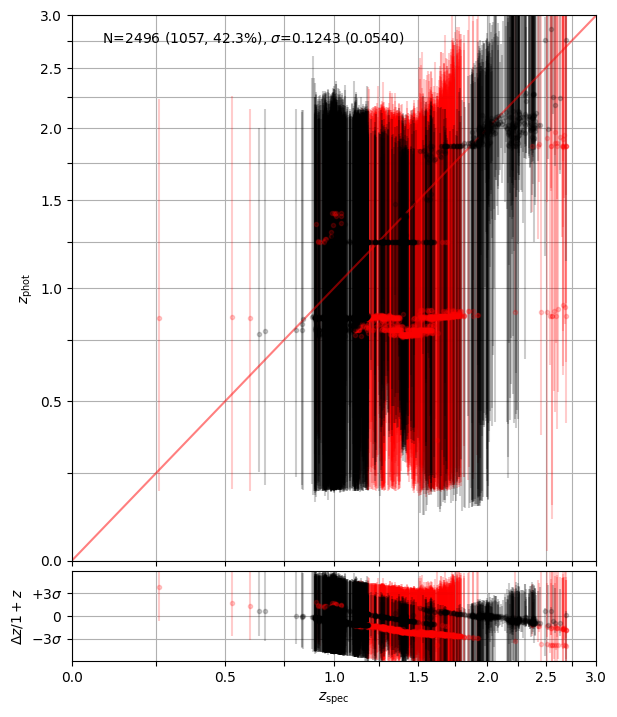

In [28]:
fig = ez.zphot_zspec(zmin=0, zmax=3, minor=0.25)

In [29]:
### UVJ
uv = -2.5*np.log10(zout['restU']/zout['restV'])
vj = -2.5*np.log10(zout['restV']/zout['restJ'])

uverr = 2.5*np.sqrt((zout['restU_err']/zout['restU'])**2+(zout['restV_err']/zout['restV'])**2)
vjerr = 2.5*np.sqrt((zout['restV_err']/zout['restV'])**2+(zout['restJ_err']/zout['restJ'])**2)

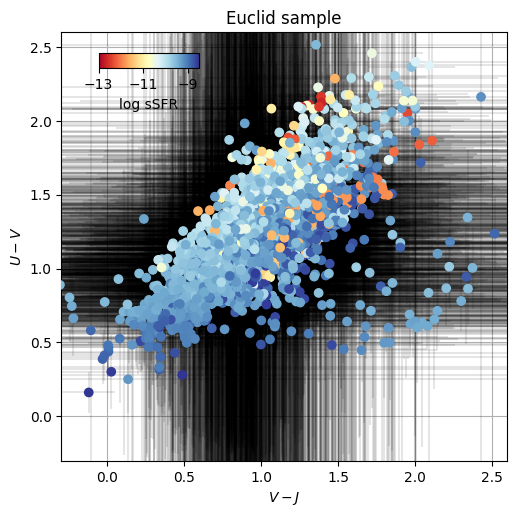

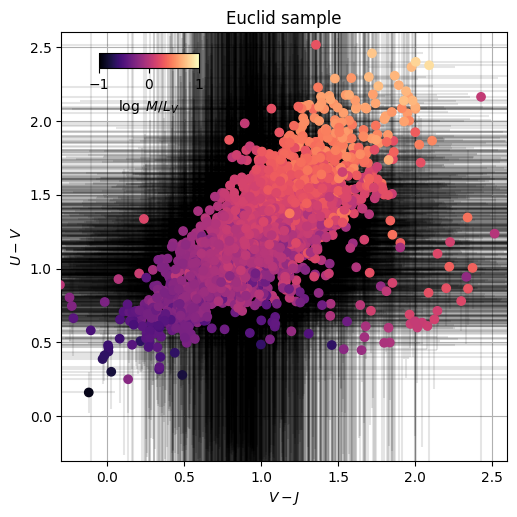

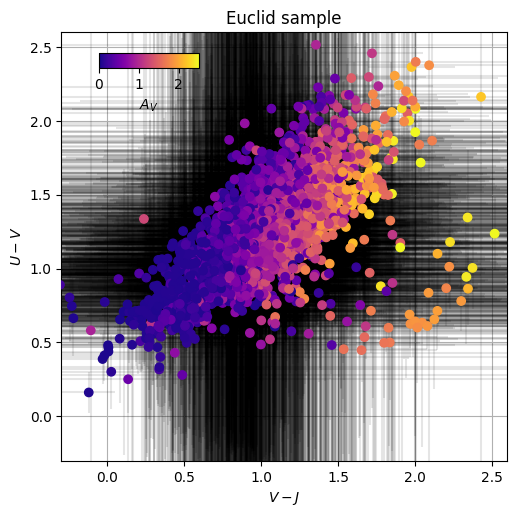

In [30]:
for show in ['ssfr', 'MLv', 'Av']:
    
    fig = plt.figure(figsize=[5,5])
    
    ax = fig.add_subplot(111)
    ax.errorbar(vj, uv, xerr=vjerr, yerr=uverr, color='k', 
                alpha=0.1, marker='.', capsize=0, linestyle='None')
    
    if show == 'ssfr':
        sc = ax.scatter(vj, uv, c=np.log10(zout['ssfr']), 
                        vmin=-13, vmax=-8.5, zorder=10, cmap='RdYlBu')
        label = 'log sSFR'
        ticks = np.arange(-13,-8,2)
    
    elif show == 'MLv':
        sc = ax.scatter(vj, uv, c=np.log10(zout['MLv']), 
                        vmin=-1, vmax=1, zorder=10, cmap='magma')
        label = r'$\log\ M/L_V$'
        ticks = np.arange(-1,1.1,1)

    elif show == 'Av':
        sc = ax.scatter(vj, uv, c=zout['Av'], vmin=0, 
                        vmax=2.5, zorder=10, cmap='plasma')
        label = r'$A_V$'
        ticks = np.arange(0,2.1,1)
    
    # Colorbar
    cax = fig.add_axes((0.18, 0.88, 0.2, 0.03))
    cb = plt.colorbar(sc, cax=cax, orientation='horizontal')
    cb.set_label(label)
    cb.set_ticks(ticks)
    
    ax.set_xlim(-0.3, 2.6)
    ax.set_ylim(-0.3, 2.6)
    
    ax.grid()
    
    ax.set_xlabel(r'$V-J$'); ax.set_ylabel(r'$U-V$')
    ax.set_title('Euclid sample')
    
    fig.tight_layout(pad=0.1)
    
    plt.savefig('Euclid_sample_{0}.pdf'.format(show))

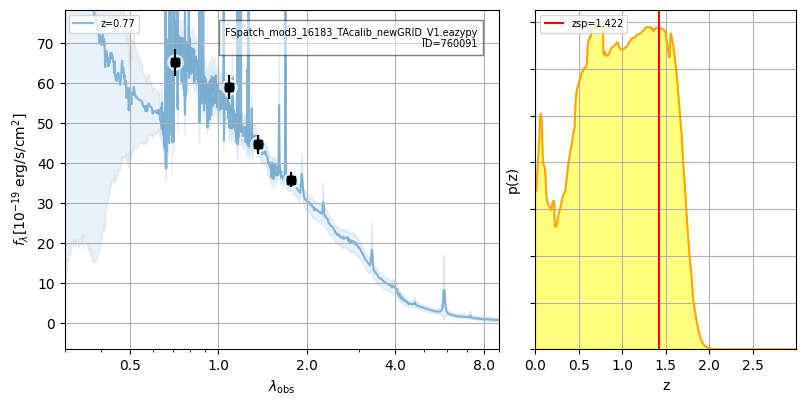

In [31]:
# Show SED
id_i = ez.cat['id'][0]
fig = ez.show_fit(id_i, show_fnu=0)

(0.0, 2.0)

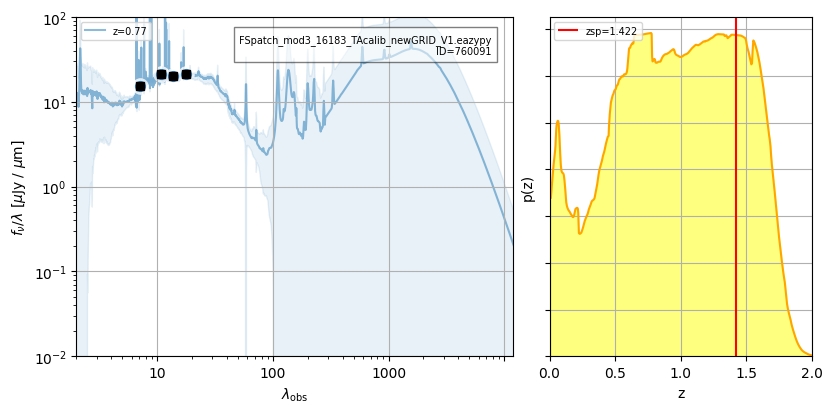

In [32]:
# nu-Fnu scaling for far-IR 
fig = ez.show_fit(id_i, show_fnu=2)

fig[0].axes[0].set_xlim(0.2, 1200)
fig[0].axes[0].set_ylim(0.01, 100)
fig[0].axes[0].loglog()
fig[0].axes[0].set_xticklabels([0.1, 1, 10, 100, 1000])
fig[0].axes[1].set_xlim(0, 2)

In [33]:
### Find IDs of specific objects to extract, same ones from the notebook
#import astropy.units as u


coords = np.array([
    [213.5336856, 57.4132505], # text={DET11}
    [213.4295991, 57.6816576], # text={DET12}
    [213.4315260, 57.8136758], # text={DET13}
    [213.4346684, 58.0398204], # text={DET14}
    [212.9621205, 57.4392532], # text={DET21}
    [213.1691144, 57.6126144], # text={DET22}
    [213.0673237, 57.8236649], # text={DET23}
    [213.0680791, 57.9809269], # text={DET24}
    [212.8071864, 57.4522919], # text={DET31}
    [212.8067834, 57.6646772], # text={DET32}
    [212.5958700, 57.7396272], # text={DET33}
    [212.8060074, 58.0138545], # text={DET34}
    [212.4446336, 57.4422826], # text={DET41}
    [212.2297985, 57.6126823], # text={DET42}
    [212.2261896, 57.8256404], # text={DET43}
    [212.4384583, 57.9828451], # text={DET44}
])

tab = Table()
tab["ra"] = coords[:,0]
tab["dec"] = coords[:,1]
print(tab)

     ra        dec    
----------- ----------
213.5336856 57.4132505
213.4295991 57.6816576
 213.431526 57.8136758
213.4346684 58.0398204
212.9621205 57.4392532
213.1691144 57.6126144
213.0673237 57.8236649
213.0680791 57.9809269
212.8071864 57.4522919
212.8067834 57.6646772
  212.59587 57.7396272
212.8060074 58.0138545
212.4446336 57.4422826
212.2297985 57.6126823
212.2261896 57.8256404
212.4384583 57.9828451


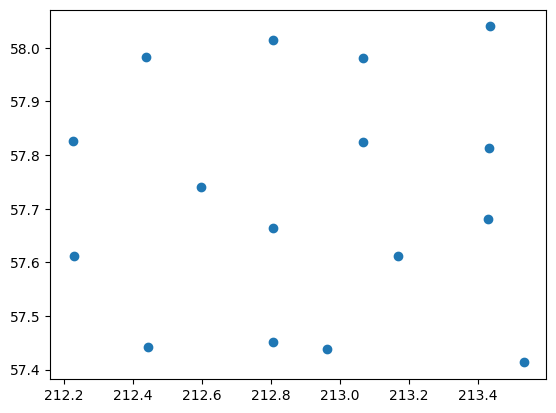

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(tab["ra"], tab["dec"])
plt.show()

In [35]:
ez.cat

<GTable length=2496>
   id            ra         ... TU_FNU_H_NISP_FLUX TU_FNU_H_NISP_ERR
                            ...         Jy                 Jy       
 int64        float64       ...      float32            float32     
-------- ------------------ ... ------------------ -----------------
  760091  213.5326853621862 ...          37.392925         1.8696463
 2131630  213.5327347549859 ...          28.422722         1.4211361
  696238 213.53278414801076 ...          26.976467         1.3488234
 7306139 213.53283354911247 ...           76.71511         3.8357556
11525864 213.53288296614792 ...           29.37089         1.4685445
10579490 213.53293238341146 ...          38.780064         1.9390032
     ...                ... ...                ...               ...
 1460246 212.22258110315803 ...           13.68844          0.684422
   73525 212.22252987521202 ...         14.2946205        0.71473104
 6645296  212.2224786305207 ...          23.235796         1.1617898
 3953848 212.22242738537045 ...          18.139072        0.90695363
12960857 212.22237612346726 ...           9.967898        0.49839494
 9788646   212.222324861103 ...           18.96981        0.94849056

In [36]:
idx3, dr3 = ez.cat.match_to_catalog_sky(tab)

In [37]:
print(idx3, dr3)

[  20  309  344  411 1070  702  970 1014 1281 1342 1774 1441 1903 2366
 2428 2056] [0.179101arcsec 0.148083arcsec 0.0784532arcsec 0.26314arcsec
 0.213979arcsec 0.288759arcsec 0.123719arcsec 0.144263arcsec
 0.167187arcsec 0.188081arcsec 0.312571arcsec 0.132209arcsec
 0.228992arcsec 0.117655arcsec 0.187838arcsec 0.192564arcsec]


In [38]:
ez.param['VERBOSITY'] = 1.
ez.fit_parallel(idx=idx3, verbose=False) 

100%|████████████████████████████████████████| 689/689 [00:02<00:00, 293.22it/s]


fit_best: 0.4 s (n_proc=1,  NOBJ=2496)


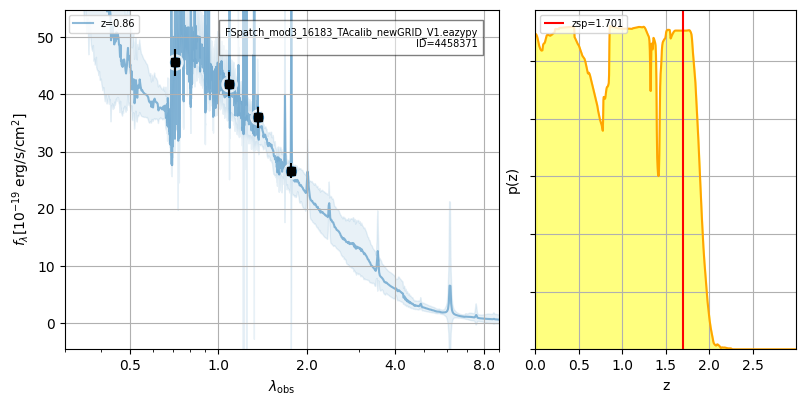

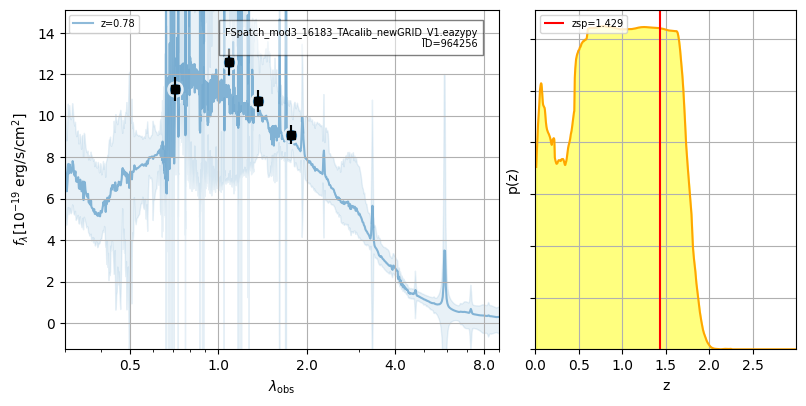

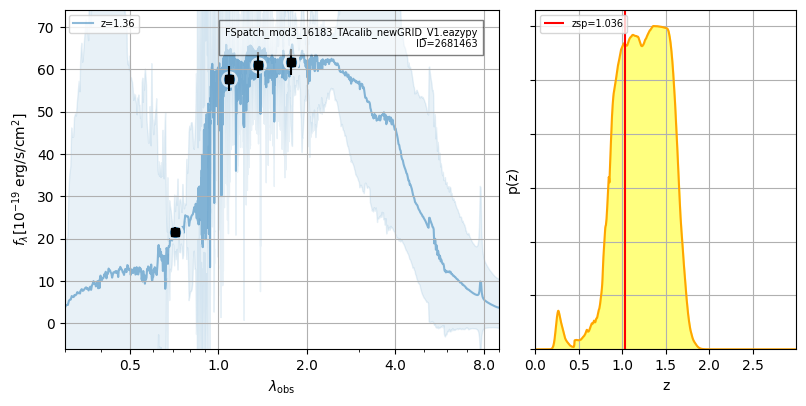

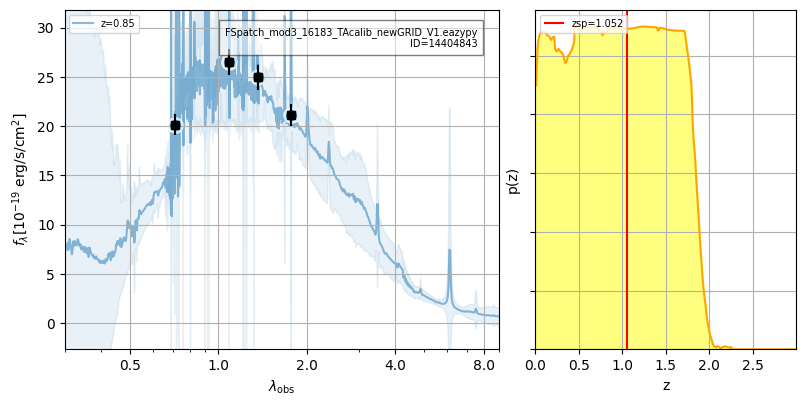

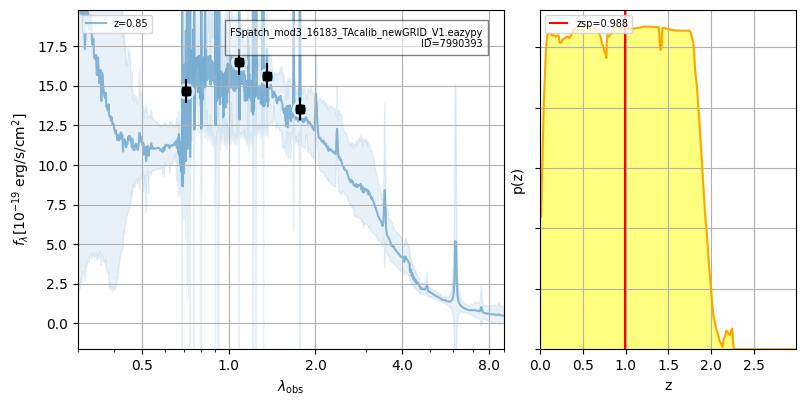

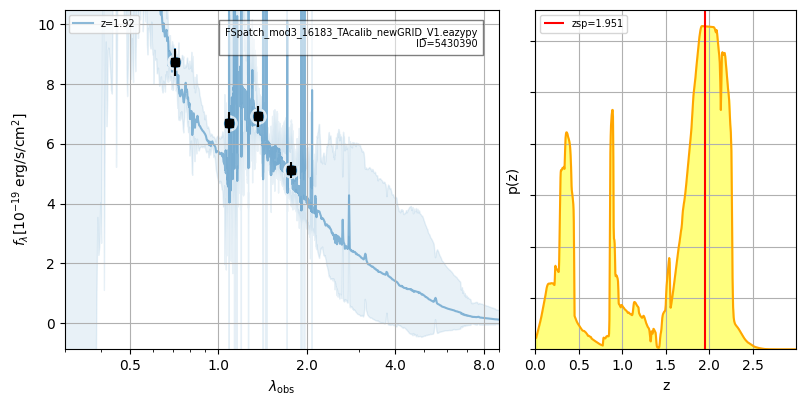

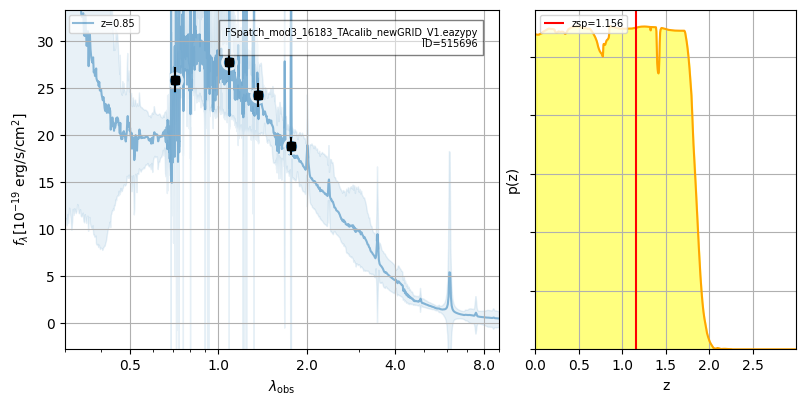

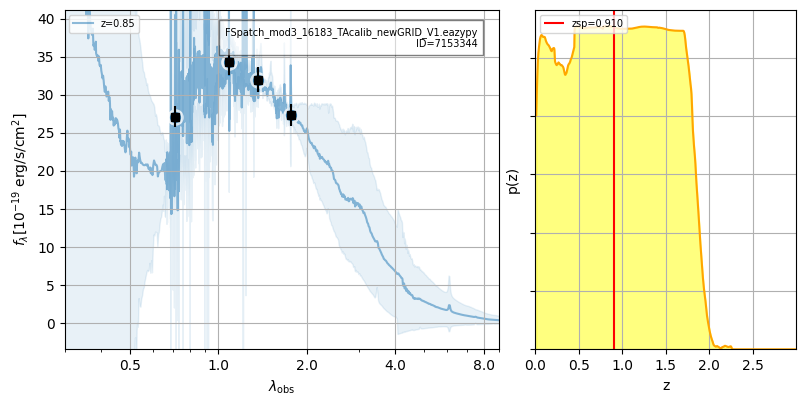

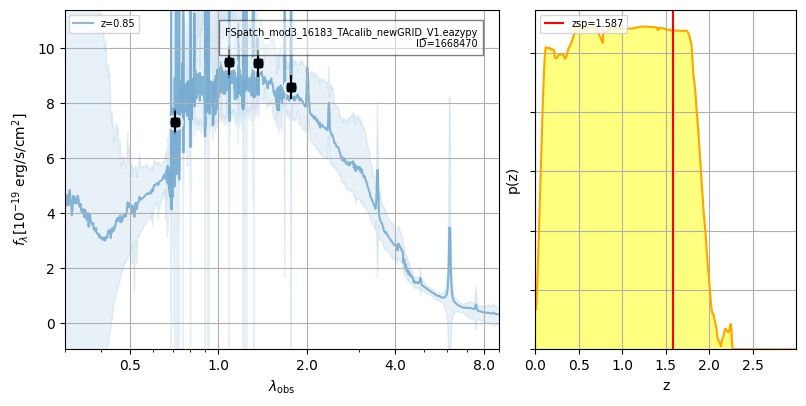

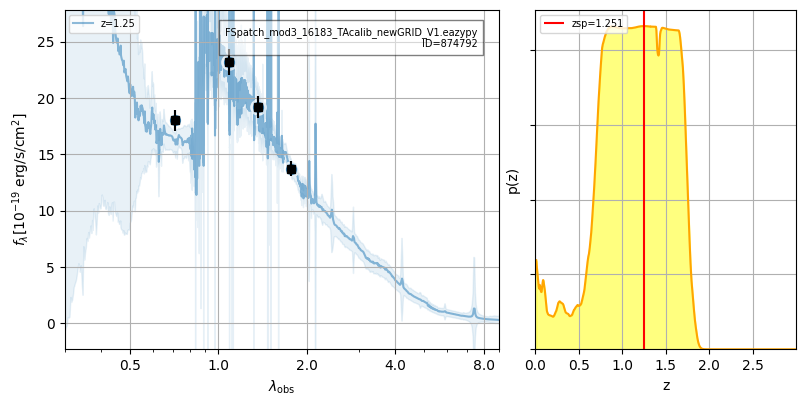

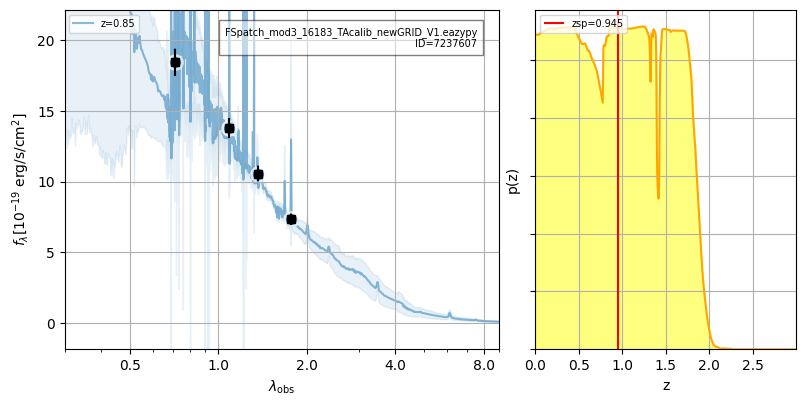

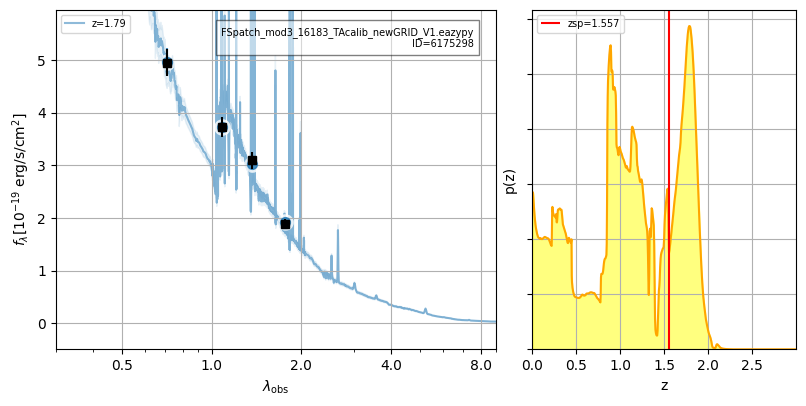

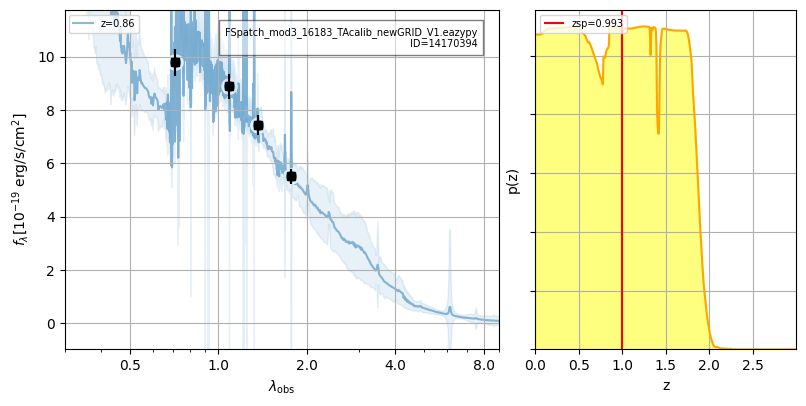

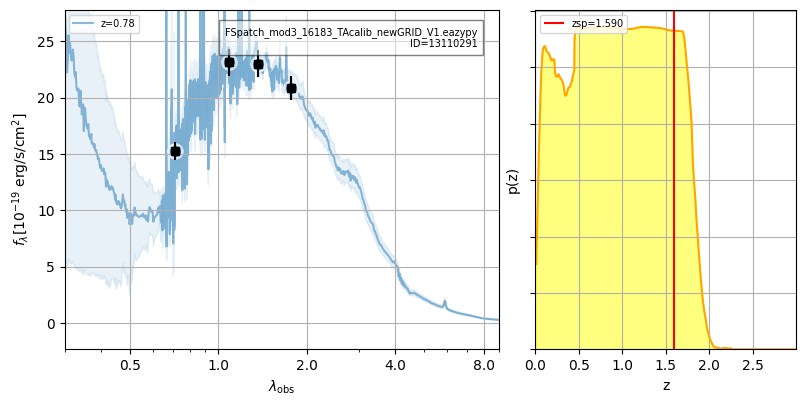

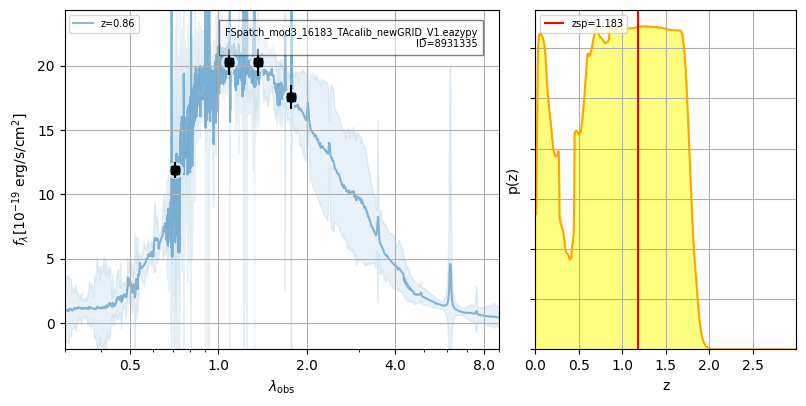

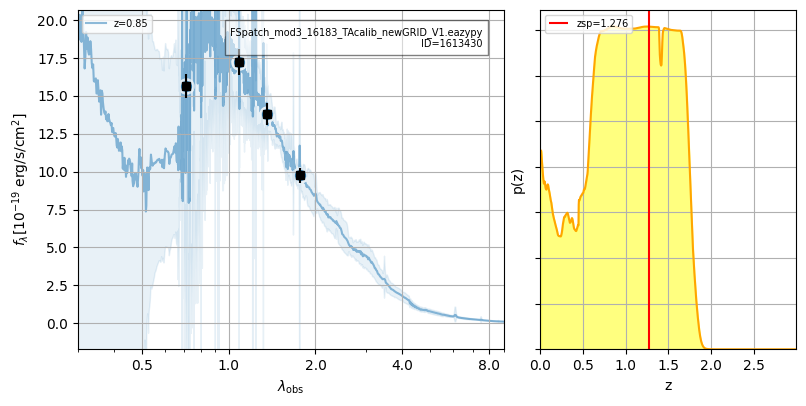

In [39]:
# Show SEDs with best-fit templates and p(z)
for ix in idx3:
    ez.show_fit(ix, id_is_idx=True)

In [40]:
## Spline templates for dummy grism continuum fits
wspline = np.arange(4200, 2.5e4)
Rspline = 50
df_spl = len(utils.log_zgrid(zr=[wspline[0], wspline[-1]], dz=1./Rspline))
tspline = utils.bspline_templates(wspline, df=df_spl+2, log=True, clip=0.0001)

In [41]:
print(os.getcwd())

/Users/gwalth/data/Roman/grizli/sims/Euclid/FSpatch_mod3_16183_TAcalib_V1_R_newGRID_2024-05-17/Extractions


In [42]:
os.chdir('{0}/{1}/Prep/'.format(HOME_PATH, root))

In [43]:
#####################################
# join all of the SExtractor catalogs
#####################################

# correct one


ref_keys = ['NUMBER', 'X_IMAGE', 'Y_IMAGE', 'X_WORLD', 'Y_WORLD', 'A_IMAGE', 'B_IMAGE', 'THETA_IMAGE', 
 'A_WORLD', 'B_WORLD', 'THETA_WORLD', 'FLUX_AUTO', 'FLUXERR_AUTO', 'MAG_AUTO', 'MAGERR_AUTO']

bands = ["VIS", "NISP_Y", "NISP_J", "NISP_H", "total"]

ref_band = "NISP_H"

import glob, re
L = glob.glob("*.cat")
print(L)
ref_cat = [l for l in L if ref_band in l][0]

phot_tbl0 = Table.read(ref_cat, format="ascii.sextractor")

#phot_ref_tbl = phot_tbl0[ref_keys]
phot_ref_tbl = Table()

for ref_key in ref_keys:
    phot_ref_tbl[ref_key.lower()] = phot_tbl0[ref_key]


for band in bands:
    for l in L:
        if band in l: 
            
            #print(l)            
            phot_tbl1 = Table.read(l, format="ascii.sextractor")
            
            #print(phot_tbl1.keys())
            for key in phot_tbl1.keys():
                #print(key.split("_"))
                if key.split("_")[0].lower() in ["flux", "fluxerr", "flag", "bkg", "mask"]:
                    #print(key)
                    #if "FLUX" in ke
                    new_col = band + "_" + key
                    
                    phot_ref_tbl[new_col.lower()] = phot_tbl1[key]
            

print(phot_ref_tbl)
phot_ref_tbl["RA"] = phot_ref_tbl["x_world"]
phot_ref_tbl["DEC"] = phot_ref_tbl["y_world"]

print(phot_ref_tbl.keys())
            

['Euclid-NISP_Y_ref.cat', 'Euclid-VIS_ref.cat', 'Euclid-total_ref.cat', 'Euclid-NISP_J_ref.cat', 'Euclid-NISP_H_ref.cat']
number  x_image   y_image  ... total_flux_radius total_flux_radius_1
          pix       pix    ...        pix                pix        
------ --------- --------- ... ----------------- -------------------
     1  7855.605  722.2397 ...             2.572                 6.1
     2 9235.5947  733.4575 ...             2.752               5.764
     3 6172.5195  750.3755 ...             3.245               6.793
     4 3146.5977  753.3884 ...             1.254                 2.8
     5 5494.6157  761.3888 ...             1.554               3.298
     6 3811.6104  763.3026 ...             1.853               4.053
   ...       ...       ... ...               ...                 ...
  1889 6854.6934 8756.3926 ...             2.193               4.708
  1890  766.5071 8736.5918 ...             2.378               4.872
  1891 3813.6216 8754.2441 ...             3.207  

In [44]:
print(len(tab))

16


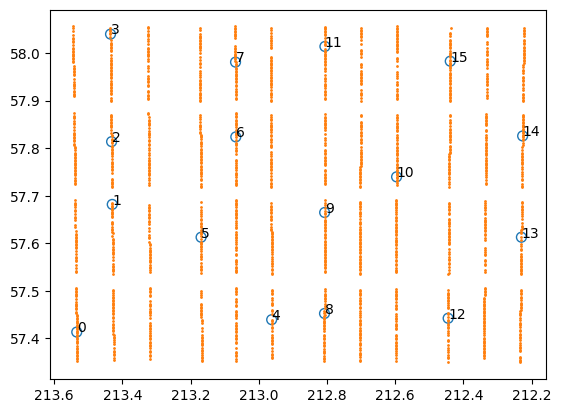

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(tab["ra"], tab["dec"], fc="none", ec="tab:blue", s=50)
ax.scatter(phot_ref_tbl["RA"], phot_ref_tbl["DEC"], s=1)

for i in range(len(tab)):
    ax.text(tab["ra"][i], tab["dec"][i], "%i" % (i))

x0,x1 = ax.get_xlim()

ax.set_xlim(x1,x0)

plt.show()

212.4384583 57.9828451
212.41068052222224 212.46623607777778
57.95506732222222 58.01062287777778


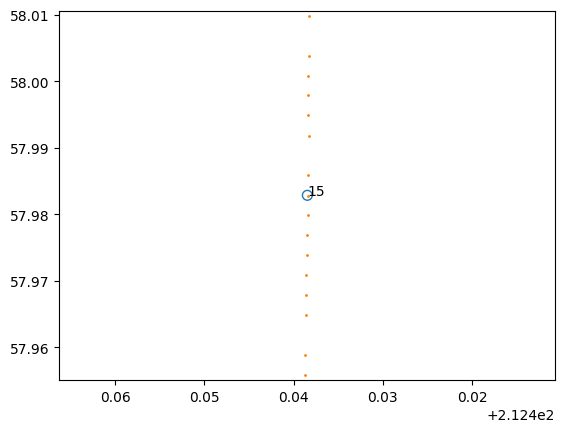

In [46]:
idx = 15

xc = tab["ra"][idx]
yc = tab["dec"][idx]
print(xc,yc)

x0 = xc - 100/3600.
x1 = xc + 100/3600.

y0 = yc - 100/3600.
y1 = yc + 100/3600.

print(x0,x1)
print(y0,y1)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(tab["ra"], tab["dec"], fc="none", ec="tab:blue", s=50)
ax.scatter(phot_ref_tbl["RA"], phot_ref_tbl["DEC"], s=1)

for i in range(len(tab)):
    if tab["ra"][i] > x0 and tab["ra"][i] < x1 and tab["dec"][i] > y0 and tab["dec"][i] < y1:
        ax.text(tab["ra"][i], tab["dec"][i], "%i" % (i))

#x0,x1 = ax.get_xlim()

ax.set_xlim(x1,x0)
ax.set_ylim(y0,y1)


plt.show()

In [47]:
os.chdir('{0}/{1}/Prep/'.format(HOME_PATH, root))
footprints = load_footprints(all_final_slitless)
print(footprints)
src_det_list = match_src_det(coords, footprints)
print(src_det_list)

{'11': array([[213.58665703,  57.51176275],
       [213.58283526,  57.34255544],
       [213.26924898,  57.34422224],
       [213.27161785,  57.51343725]]), '12': array([[213.59038275,  57.69511336],
       [213.58657035,  57.52590415],
       [213.27140217,  57.52755005],
       [213.27374394,  57.69676693]]), '13': array([[213.594124  ,  57.87825552],
       [213.59005587,  57.70904765],
       [213.27329639,  57.71081362],
       [213.27587597,  57.88002981]]), '14': array([[213.59769568,  58.0614538 ],
       [213.59418713,  57.89224438],
       [213.27581814,  57.89369769],
       [213.27781985,  58.062914  ]]), '21': array([[213.21797247,  57.51331884],
       [213.2158509 ,  57.34409883],
       [212.90223949,  57.34484946],
       [212.90290778,  57.51407294]]), '22': array([[213.21992435,  57.69648366],
       [213.21786762,  57.52726171],
       [212.9026759 ,  57.52796827],
       [212.90326165,  57.69719352]]), '23': array([[213.22217946,  57.87982764],
       [213.2203105 

In [48]:
# match catalog to specific sources

verb = 0

coord_idx = []
tbl_idx = []
tbl_num = []

# coords or tabs
for i,row in enumerate(coords):
    ra_src, dec_src = row

    ind, dr = match_src_coords(phot_ref_tbl["RA"], phot_ref_tbl["DEC"], ra_src, dec_src)
    
    if verb:
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        ax1.hist(dr, range(0,30))
        plt.show()
    
    if dr[ind] < 1.0: # arcsec       
        print(i, ind, dr[ind], phot_ref_tbl["number"][ind])
        coord_idx.append(i)
        tbl_idx.append(ind)
        tbl_num.append(phot_ref_tbl["number"][ind])
    else:
        print("SKIPPING %i" % (i))

print()
print("coord_idx =", coord_idx)
print("tbl_idx =", tbl_idx)
print("tbl_num =", tbl_num)

0 186 0.11726814347411466 187
1 917 0.22507024918057605 918
2 1495 0.042701462568558515 1496
3 991 0.3489572119863879 992
4 264 0.18916995381729765 265
SKIPPING 5
6 1466 0.08363830672386656 1467
7 1072 0.48425100084779826 1073
8 301 0.10682603969296935 302
9 860 0.1385095827923107 861
10 1720 0.07995828658087799 1721
SKIPPING 11
SKIPPING 12
13 709 0.1983130433664159 710
14 1458 0.15187998334607908 1459
15 1071 0.15514238690874954 1072

coord_idx = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 13, 14, 15]
tbl_idx = [186, 917, 1495, 991, 264, 1466, 1072, 301, 860, 1720, 709, 1458, 1071]
tbl_num = [187, 918, 1496, 992, 265, 1467, 1073, 302, 861, 1721, 710, 1459, 1072]


In [49]:
print("src_det_list =", src_det_list)
# full list based on coords
det_ids = [src_det_list[idx] for idx in coord_idx]
# list based on what is found 
print("det_ids =", det_ids)

src_det_list = ['11', '12', '13', '14', '21', '22', '23', '24', '31', '32', '33', '34', '41', '42', '43', '44']
det_ids = ['11', '12', '13', '14', '21', '23', '24', '31', '32', '33', '42', '43', '44']


In [50]:
print("coord_idx =", coord_idx)
print("tbl_idx =", tbl_idx)
print("tbl_num =", tbl_num)
#print("src_det_list =", src_det_list)
print("det_ids =", det_ids)

coord_idx = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 13, 14, 15]
tbl_idx = [186, 917, 1495, 991, 264, 1466, 1072, 301, 860, 1720, 709, 1458, 1071]
tbl_num = [187, 918, 1496, 992, 265, 1467, 1073, 302, 861, 1721, 710, 1459, 1072]
det_ids = ['11', '12', '13', '14', '21', '23', '24', '31', '32', '33', '42', '43', '44']


In [51]:
os.chdir('{0}/{1}/Extractions/'.format(HOME_PATH, root))

In [52]:
#fwhm = 395 # km/s
fwhm = 400 # km/s

# First is set with combined emission line complexes for the redshift fit 
# (don't allow infinite freedom) of the line ratios / fluxes
temp0 = grizli.utils.load_templates(
    fwhm=fwhm, 
    line_complexes=True, 
    stars=False,
    full_line_list=None,  
    continuum_list=None,
    fsps_templates=True
)

# Second set has individual line templates for fitting the line fluxes
temp1 = grizli.utils.load_templates(
    fwhm=fwhm, 
    line_complexes=False, 
    stars=False,
    full_line_list=None, 
    continuum_list=None,
    fsps_templates=True
)

phot_obj = photoz.EazyPhot(ez, grizli_templates=temp0, zgrid=ez.zgrid) 

100%|███████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]

Template   0: fsps/fsps_QSF_12_v3_nolines_001.dat (NZ=1).
Template   1: fsps/fsps_QSF_12_v3_nolines_002.dat (NZ=1).
Template   2: fsps/fsps_QSF_12_v3_nolines_003.dat (NZ=1).
Template   3: fsps/fsps_QSF_12_v3_nolines_004.dat (NZ=1).
Template   4: fsps/fsps_QSF_12_v3_nolines_005.dat (NZ=1).
Template   5: fsps/fsps_QSF_12_v3_nolines_006.dat (NZ=1).
Template   6: fsps/fsps_QSF_12_v3_nolines_007.dat (NZ=1).
Template   7: fsps/fsps_QSF_12_v3_nolines_008.dat (NZ=1).
Template   8: fsps/fsps_QSF_12_v3_nolines_009.dat (NZ=1).
Template   9: fsps/fsps_QSF_12_v3_nolines_010.dat (NZ=1).
Template  10: fsps/fsps_QSF_12_v3_nolines_011.dat (NZ=1).
Template  11: fsps/fsps_QSF_12_v3_nolines_012.dat (NZ=1).
Template  12: line Ha+NII+SII+SIII+He+PaB (NZ=1).
Template  13: line OIII+Hb+Hg+Hd (NZ=1).
Template  14: line OII+Ne (NZ=1).
Template  15: line Gal-UV-lines (NZ=1).


20
309
344
411
1070
702
970
1014
1281
1342
1774
1441
1903
2366
2428
2056


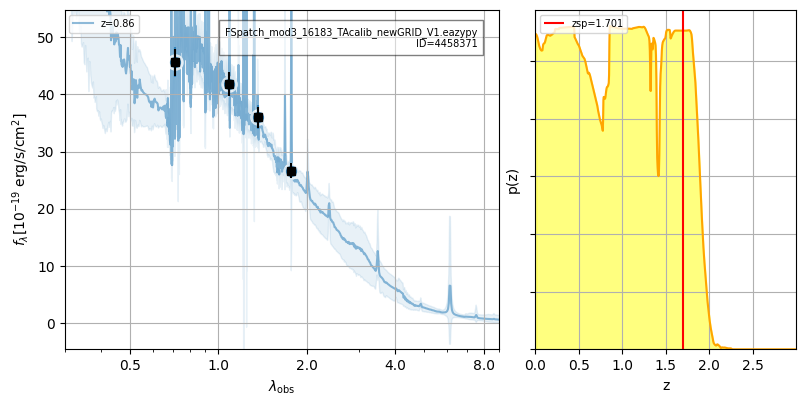

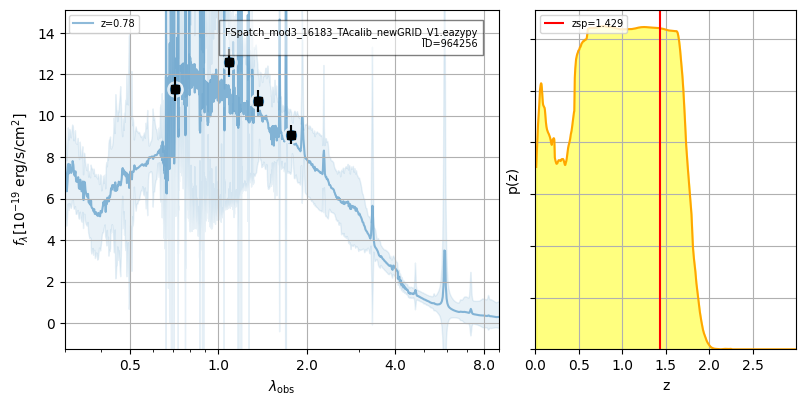

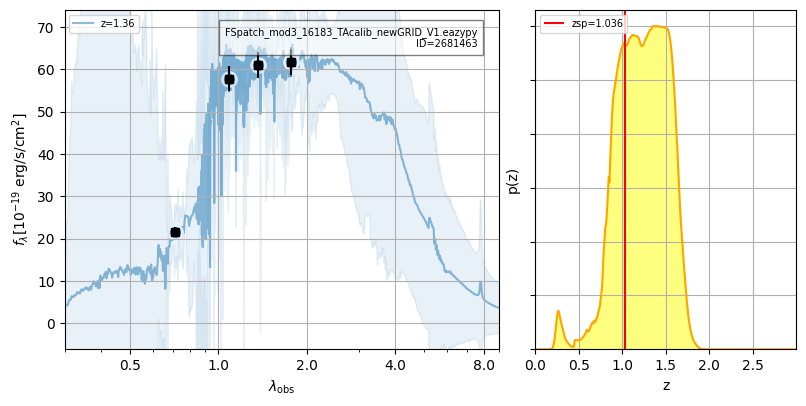

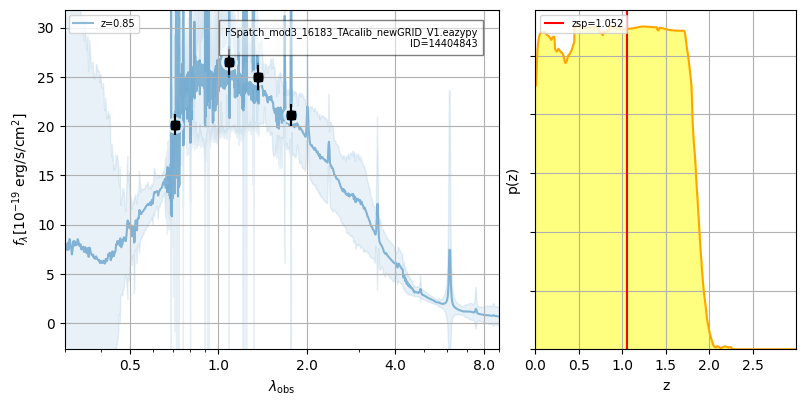

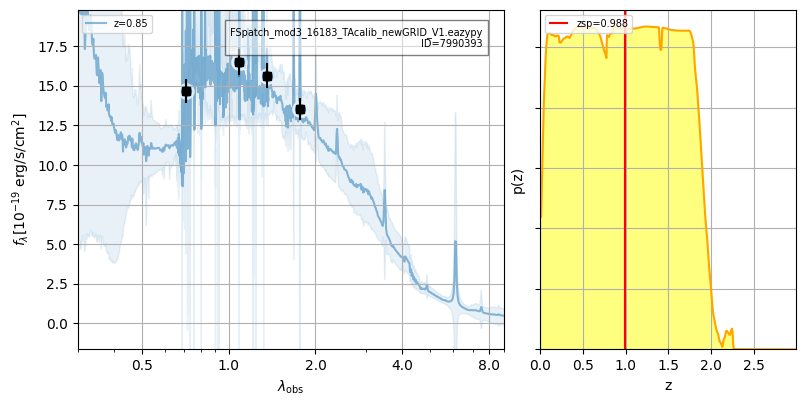

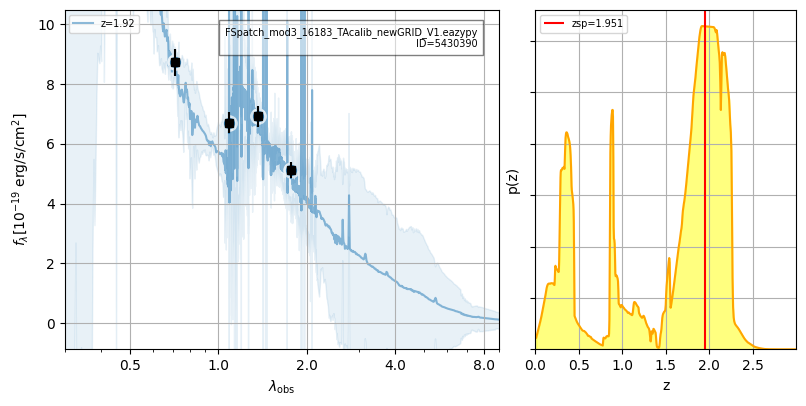

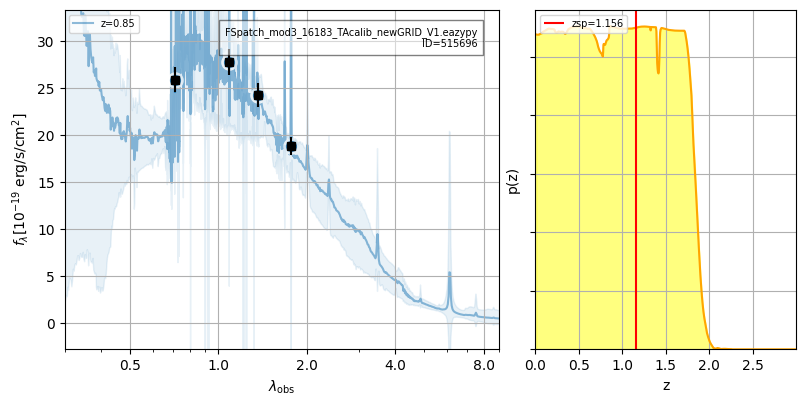

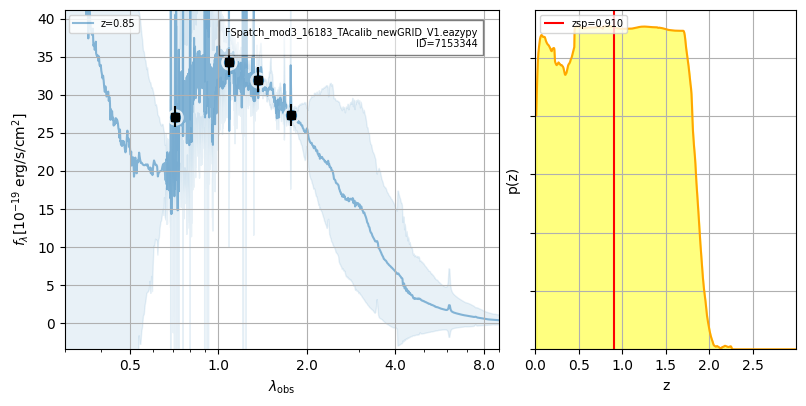

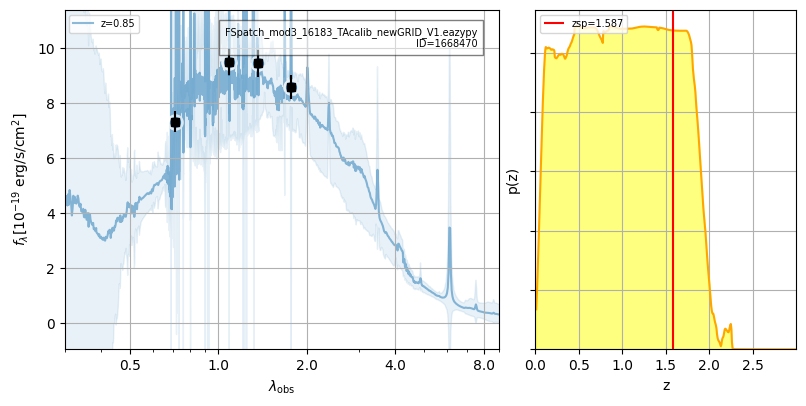

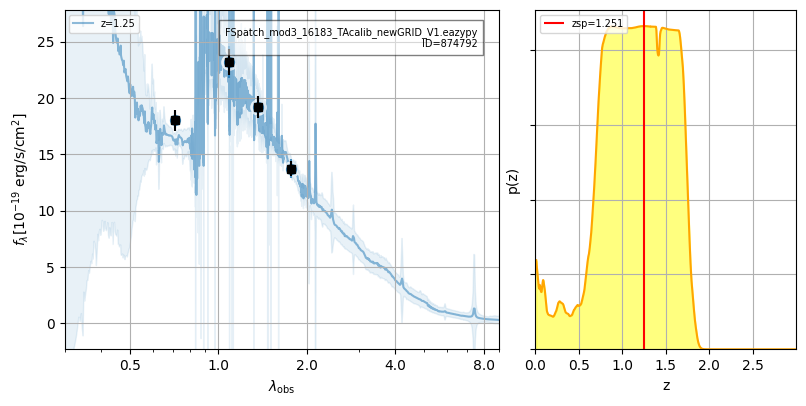

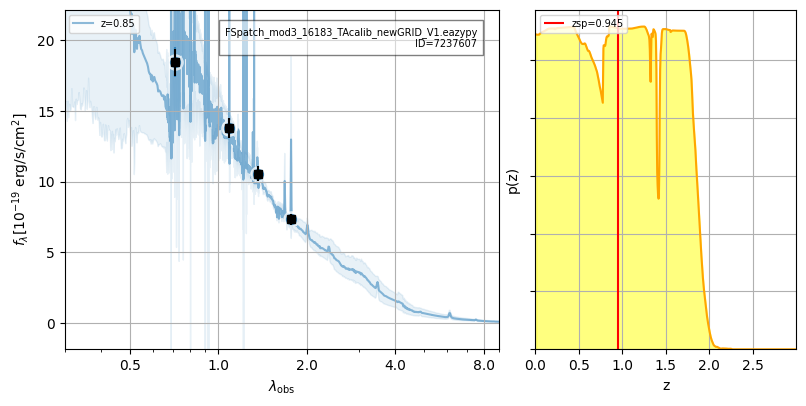

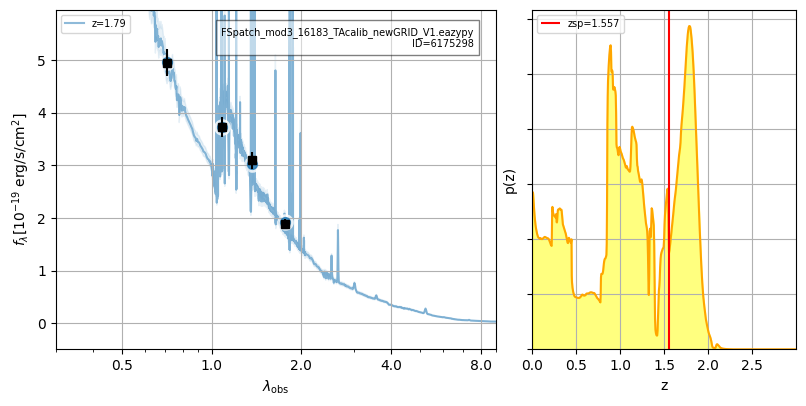

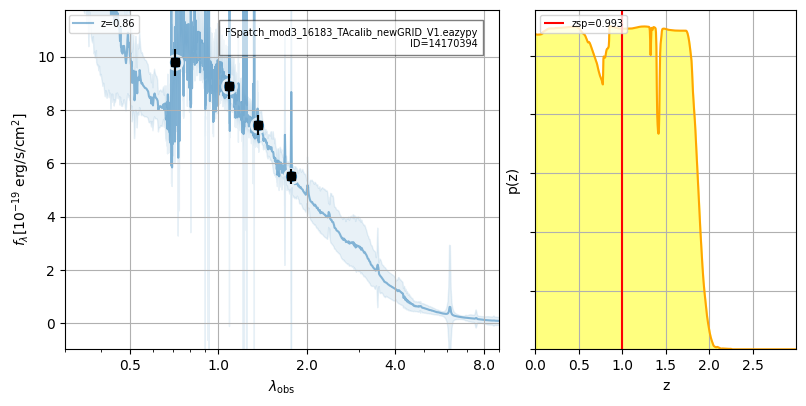

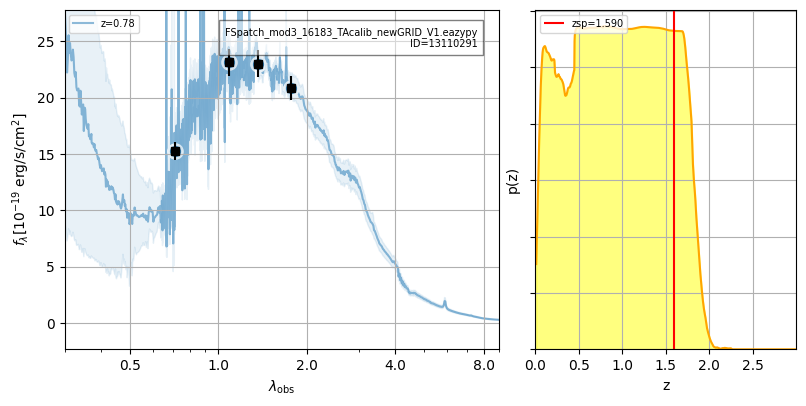

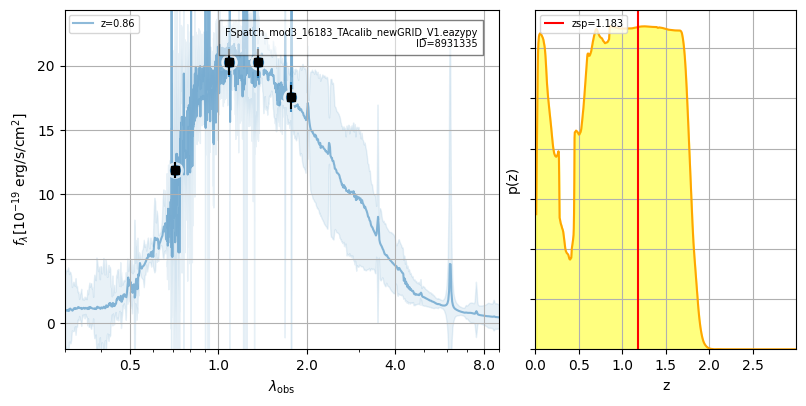

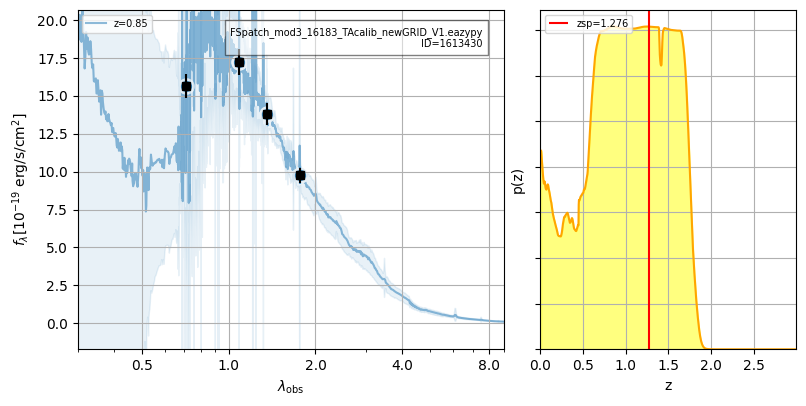

In [79]:
# Show SEDs with best-fit templates and p(z)
for ix in idx3:
    print(ix)
    ez.show_fit(ix, id_is_idx=True)

In [54]:
os.chdir('{0}/{1}/Prep/'.format(HOME_PATH, root))

In [55]:
os.chdir('{0}/{1}/Extractions/'.format(HOME_PATH, root))

In [56]:
print("coord_idx =", coord_idx)
print("tbl_idx =", tbl_idx)
print("tbl_num =", tbl_num)
#print("src_det_list =", src_det_list)
print("det_ids =", det_ids)

coord_idx = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 13, 14, 15]
tbl_idx = [186, 917, 1495, 991, 264, 1466, 1072, 301, 860, 1720, 709, 1458, 1071]
tbl_num = [187, 918, 1496, 992, 265, 1467, 1073, 302, 861, 1721, 710, 1459, 1072]
det_ids = ['11', '12', '13', '14', '21', '23', '24', '31', '32', '33', '42', '43', '44']


In [ ]:
# fit redshifts all redshifts (only needs to be done once) - loop

In [ ]:
for i,(id, det_num) in enumerate(zip(tbl_num, det_ids)):
    print(i, id, det_num)
    det = 'DET' + det_num
    fit_redshift_from_id(id, det, HOME_PATH, root)

In [ ]:
# load photometry - loop

0 187 11
GLW made it!
GLW made it!
load_master_fits: FSpatch_mod3_16183_TAcalib_V1_R_newGRID_2024-05-17_DET11_00187.beams.fits
/Users/gwalth/data/Roman/grizli/grizli/CONF/Euclid/GLWv4/NISP_RGS000p0_12.conf
1 Euclid_FRAME1_DET11_slitless_final.fits RED
GLW made it!
GLW made it!
Catalog ID: 4458371, dr=0.25 arcsec, zphot=0.857

`phot` keys: ['source', 'flam', 'eflam', 'filters', 'tempfilt', 'ext_corr', 'pz', 'z_spec']

source:
 unknown

flam:
 [4.56180297e-18 4.17760220e-18 3.60040393e-18 2.66648150e-18]

eflam:
 [2.32607228e-19 2.13016752e-19 1.83585295e-19 1.35964410e-19]

filters:
 ['Euclid_VIS.vis.dat lambda_c= 7.10338e+03 SPV02-from-SVO-service-03.06.22', 'Euclid_NISP.Y.dat lambda_c= 1.08311e+04 SPV02-from-SVO-service-03.06.22', 'Euclid_NISP.J.dat lambda_c= 1.36354e+04 SPV02-from-SVO-service-03.06.22', 'Euclid_NISP.H.dat lambda_c= 1.76796e+04 SPV02-from-SVO-service-03.06.22']

tempfilt:

ext_corr:
 [1. 1. 1. 1.]

pz:
 None

z_spec:
 1.7013824
1 918 12
GLW made it!
GLW made it!
load_

9 1721 33
GLW made it!
GLW made it!
load_master_fits: FSpatch_mod3_16183_TAcalib_V1_R_newGRID_2024-05-17_DET33_01721.beams.fits
/Users/gwalth/data/Roman/grizli/grizli/CONF/Euclid/GLWv4/NISP_RGS000p0_12.conf
1 Euclid_FRAME1_DET33_slitless_final.fits RED
GLW made it!
GLW made it!
Catalog ID: 7237607, dr=0.23 arcsec, zphot=0.853

`phot` keys: ['source', 'flam', 'eflam', 'filters', 'tempfilt', 'ext_corr', 'pz', 'z_spec']

source:
 unknown

flam:
 [1.84610947e-18 1.37752239e-18 1.05759119e-18 7.34538381e-19]

eflam:
 [9.41334843e-20 7.02401347e-20 5.39267826e-20 3.74542567e-20]

filters:
 ['Euclid_VIS.vis.dat lambda_c= 7.10338e+03 SPV02-from-SVO-service-03.06.22', 'Euclid_NISP.Y.dat lambda_c= 1.08311e+04 SPV02-from-SVO-service-03.06.22', 'Euclid_NISP.J.dat lambda_c= 1.36354e+04 SPV02-from-SVO-service-03.06.22', 'Euclid_NISP.H.dat lambda_c= 1.76796e+04 SPV02-from-SVO-service-03.06.22']

tempfilt:

ext_corr:
 [1. 1. 1. 1.]

pz:
 None

z_spec:
 0.9448219
10 710 42
GLW made it!
GLW made it!
loa

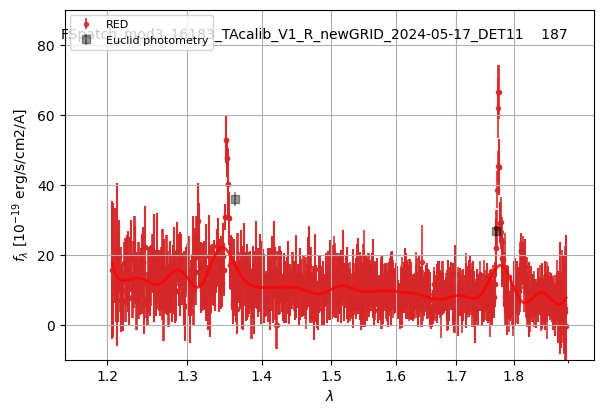

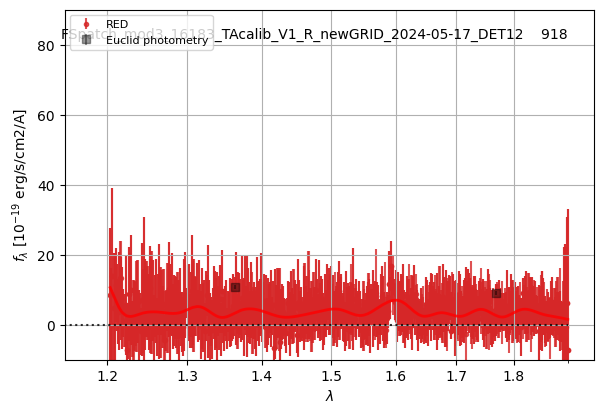

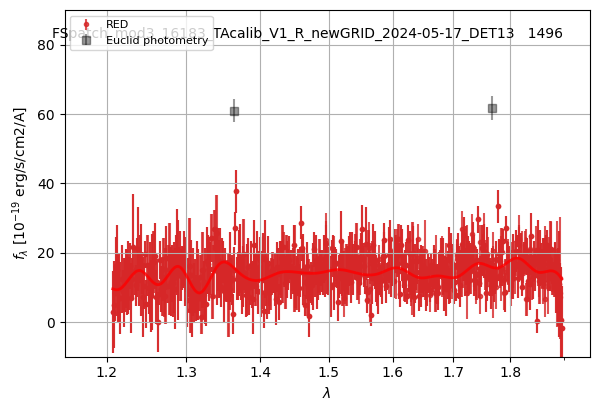

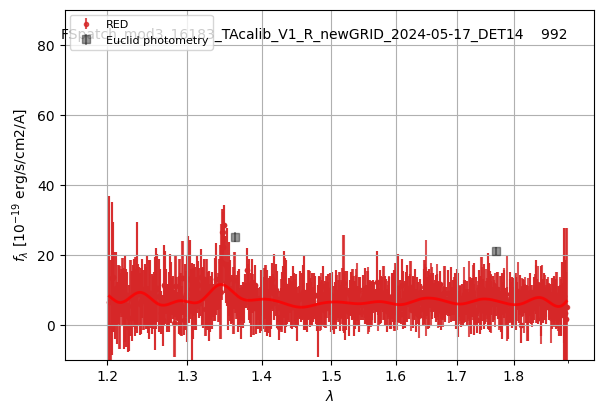

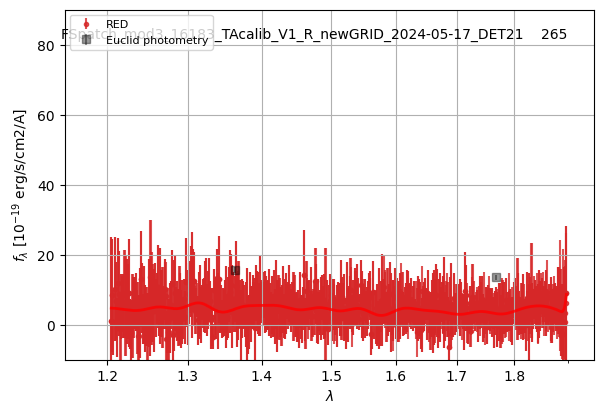

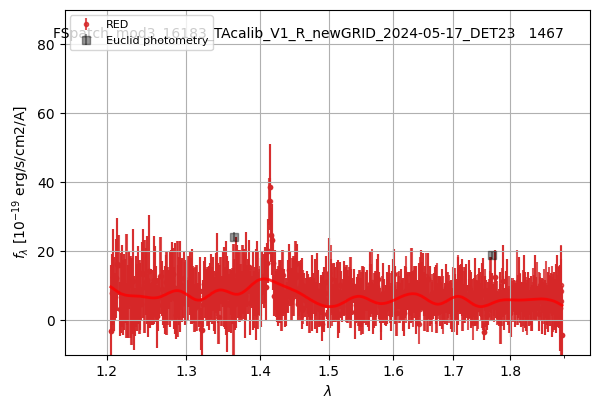

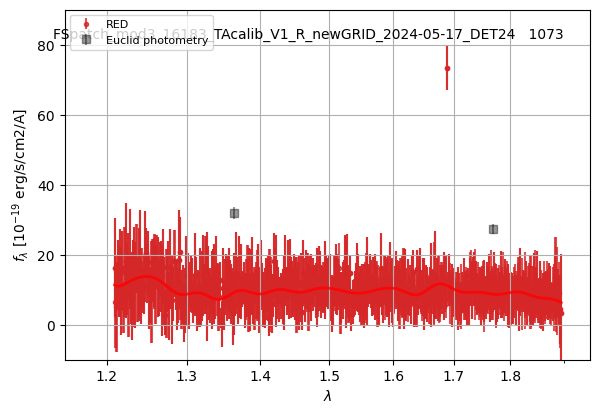

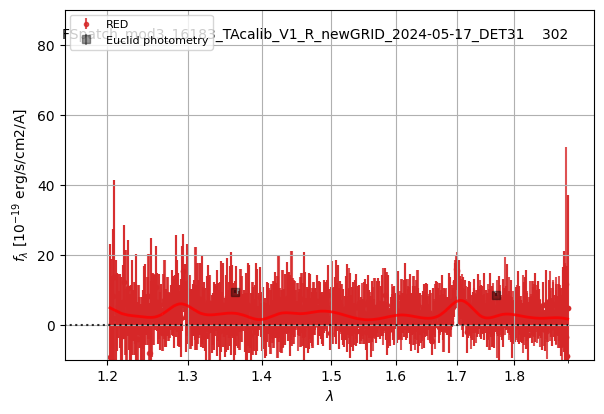

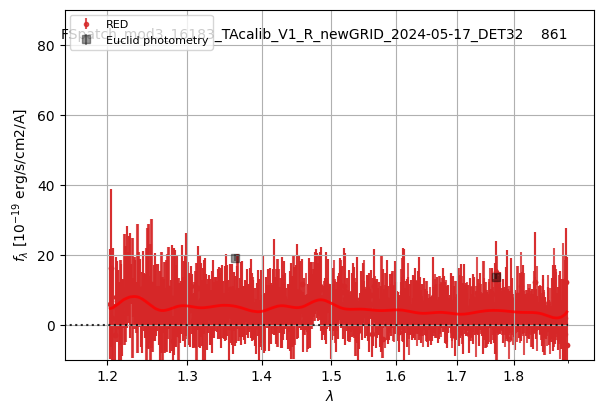

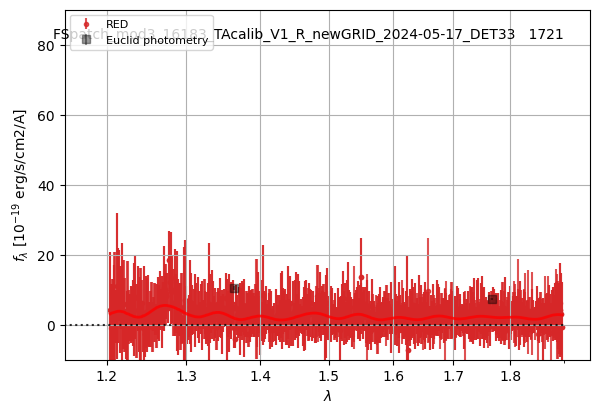

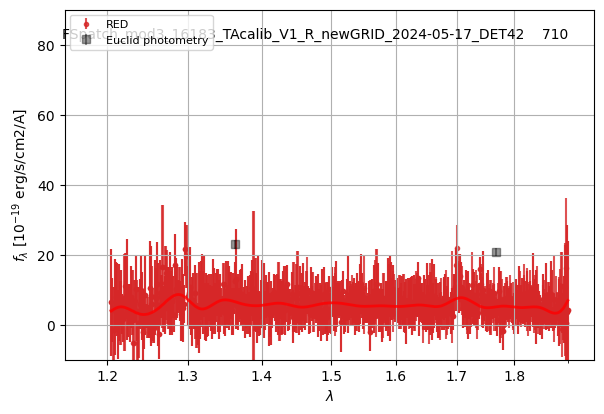

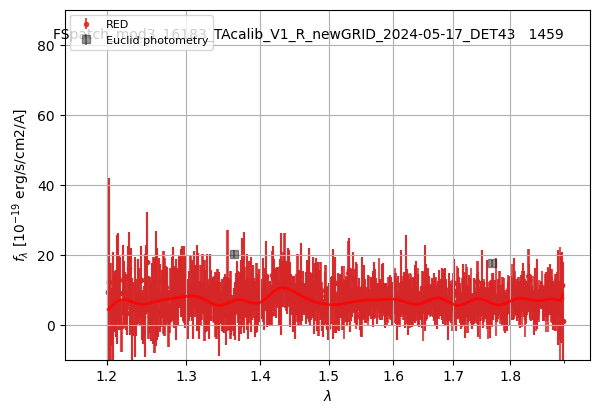

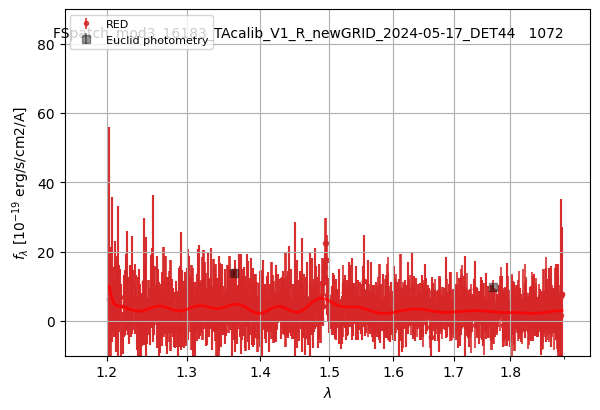

In [57]:
for i,(id, det_num) in enumerate(zip(tbl_num, det_ids)):    
    print(i, id, det_num)
    det = 'DET' + det_num
    load_phot_from_id(id, det, HOME_PATH, root)

0 187 11
GLW made it!
GLW made it!
load_master_fits: FSpatch_mod3_16183_TAcalib_V1_R_newGRID_2024-05-17_DET11_00187.beams.fits
/Users/gwalth/data/Roman/grizli/grizli/CONF/Euclid/GLWv4/NISP_RGS000p0_12.conf
1 Euclid_FRAME1_DET11_slitless_final.fits RED
GLW made it!
GLW made it!
Catalog ID: 4458371, dr=0.25 arcsec, zphot=0.857

`phot` keys: ['source', 'flam', 'eflam', 'filters', 'tempfilt', 'ext_corr', 'pz', 'z_spec']

source:
 unknown

flam:
 [4.56180297e-18 4.17760220e-18 3.60040393e-18 2.66648150e-18]

eflam:
 [2.32607228e-19 2.13016752e-19 1.83585295e-19 1.35964410e-19]

filters:
 ['Euclid_VIS.vis.dat lambda_c= 7.10338e+03 SPV02-from-SVO-service-03.06.22', 'Euclid_NISP.Y.dat lambda_c= 1.08311e+04 SPV02-from-SVO-service-03.06.22', 'Euclid_NISP.J.dat lambda_c= 1.36354e+04 SPV02-from-SVO-service-03.06.22', 'Euclid_NISP.H.dat lambda_c= 1.76796e+04 SPV02-from-SVO-service-03.06.22']

tempfilt:

ext_corr:
 [1. 1. 1. 1.]

pz:
 None

z_spec:
 1.7013824
Time to compute: 0.19 s
index = 21
ID = 

Time to compute: 0.18 s
index = 34
ID = 1668470
8 861 32
GLW made it!
GLW made it!
load_master_fits: FSpatch_mod3_16183_TAcalib_V1_R_newGRID_2024-05-17_DET32_00861.beams.fits
/Users/gwalth/data/Roman/grizli/grizli/CONF/Euclid/GLWv4/NISP_RGS000p0_12.conf
1 Euclid_FRAME1_DET32_slitless_final.fits RED
GLW made it!
GLW made it!
Catalog ID: 874792, dr=0.17 arcsec, zphot=1.245

`phot` keys: ['source', 'flam', 'eflam', 'filters', 'tempfilt', 'ext_corr', 'pz', 'z_spec']

source:
 unknown

flam:
 [1.80192912e-18 2.31822539e-18 1.91763525e-18 1.37356365e-18]

eflam:
 [9.18807168e-20 1.18206768e-19 9.77805922e-20 7.00382777e-20]

filters:
 ['Euclid_VIS.vis.dat lambda_c= 7.10338e+03 SPV02-from-SVO-service-03.06.22', 'Euclid_NISP.Y.dat lambda_c= 1.08311e+04 SPV02-from-SVO-service-03.06.22', 'Euclid_NISP.J.dat lambda_c= 1.36354e+04 SPV02-from-SVO-service-03.06.22', 'Euclid_NISP.H.dat lambda_c= 1.76796e+04 SPV02-from-SVO-service-03.06.22']

tempfilt:

ext_corr:
 [1. 1. 1. 1.]

pz:
 None

z_spec:
 1.2

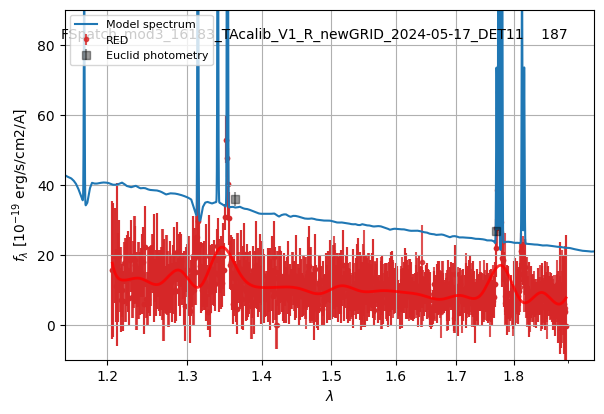

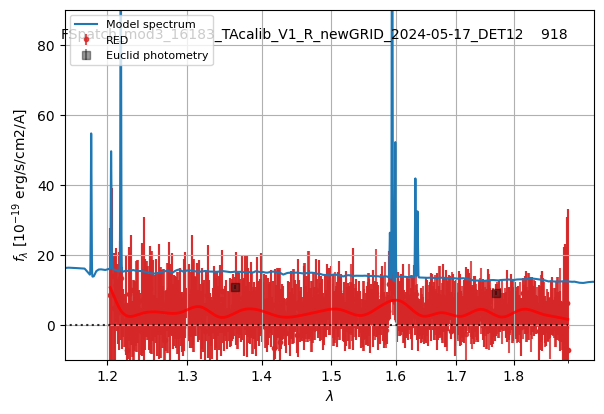

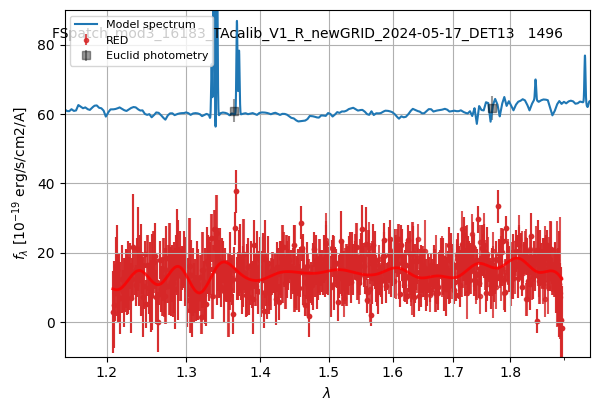

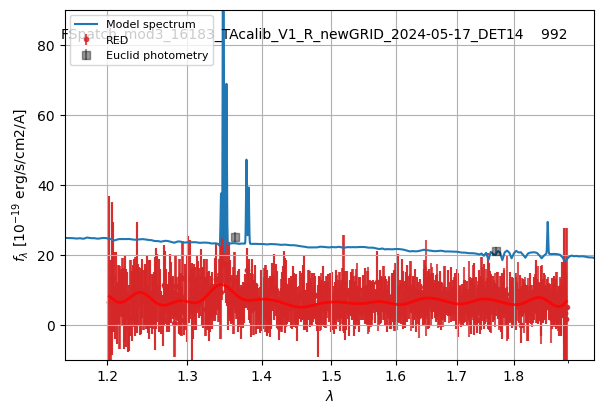

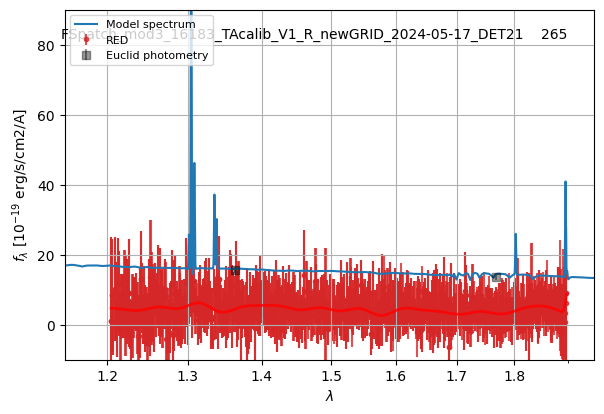

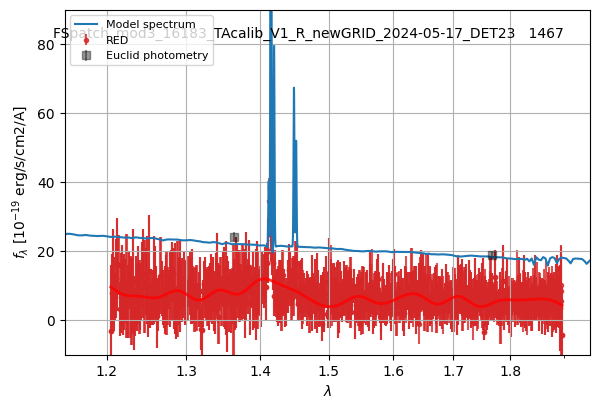

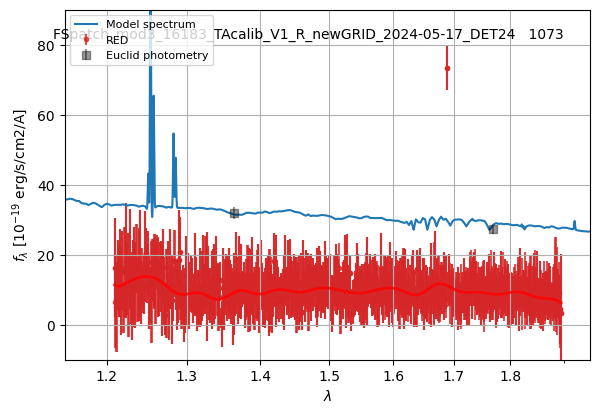

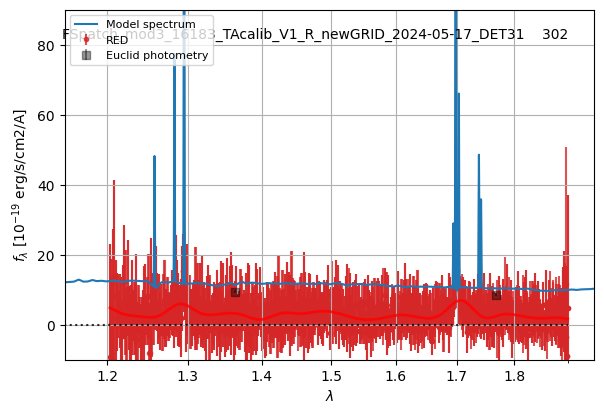

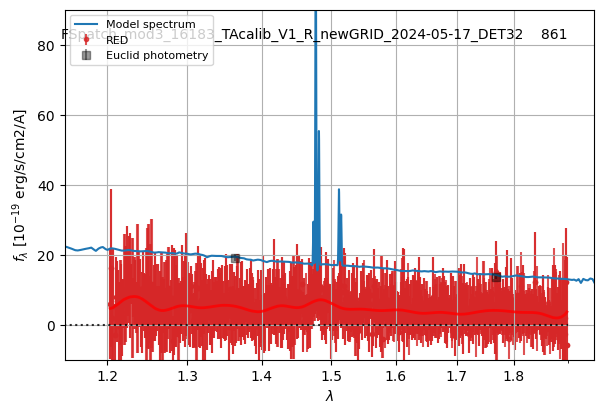

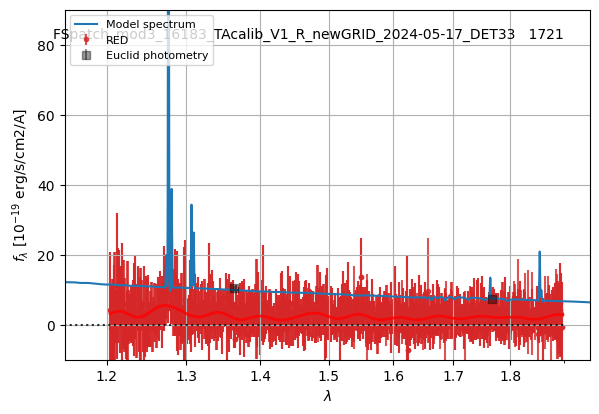

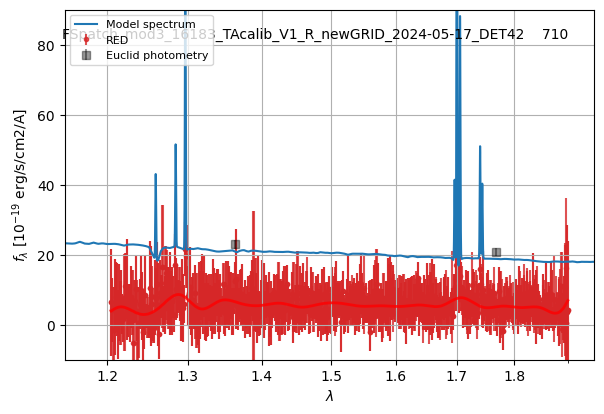

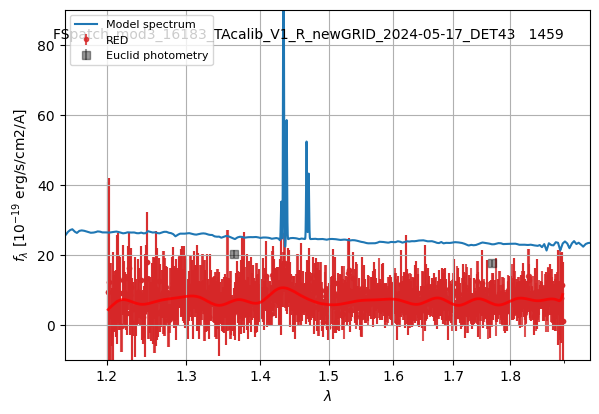

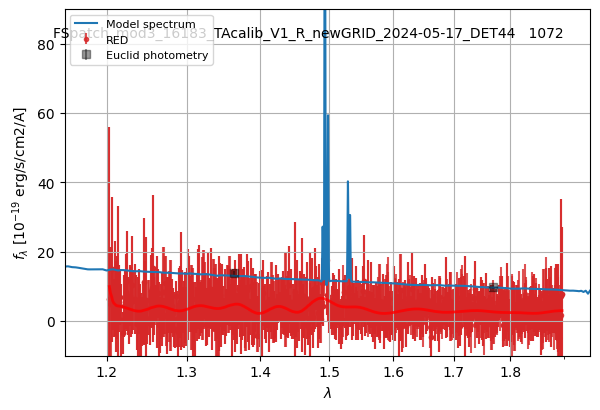

In [58]:
euclid_sims_path = "/Users/gwalth/data/Roman/grizli/sims/Euclid/Raw/EuclidSIMS/"
root = "FSpatch_mod3_16183_TAcalib_V1_R_newGRID_2024-05-17"
frame = 1

for i,(id, det_num) in enumerate(zip(tbl_num, det_ids)):    
    print(i, id, det_num)
    det = 'DET' + det_num
    model_spectra_file = euclid_model_spectra_prep(det_num, frame, euclid_sims_path, root)
    load_phot_model_from_id(id, det, HOME_PATH, root, model_spectra_file)

In [59]:
print(len(ez.zbest))

2496


In [60]:
print(ez.__dict__.keys())

dict_keys(['param_file', 'translate_file', 'zeropoint_file', 'random_seed', 'param', 'translate', 'templates', 'zgrid', 'trdz', 'cosmology', 'fixed_cols', 'RES', 'cat', 'prior_mag_cat', 'filters', 'flux_columns', 'err_columns', 'f_numbers', 'fnu', 'spatial_offset', 'fmodel', 'efmodel', 'ext_corr', 'ext_redden', 'efnu_orig', 'efnu', 'ok_data', 'nusefilt', 'lc_reddest', 'lc_zmax', 'clip_wavelength', 'idx', 'zp', 'full_logprior', 'prior_mags', 'prior_data', 'lnp', 'chi2_fit', 'lnp_beta', 'lnpmax', 'zml', 'zbest', 'chi2_best', 'coeffs_best', 'fit_coeffs', 'coeffs_draws', 'get_err', 'tempfilt', 'TEF', 'TEFgrid', 'tef_lnp', 'ubvj', 'zbest_grid', 'lnp_with_prior', 'lnp_with_beta_prior', 'ZML_WITH_PRIOR', 'ZML_WITH_BETA_PRIOR', 'ZPHOT_USER', 'ZPHOT_AT_ZSPEC', 'zbest_risk', 'error_residuals_update', 'Rz', 'ubvj_tempfilt', 'ubvj_lc', 'ubvj_f_numbers'])


In [ ]:
ix = 186

In [ ]:
# example fitting redshifts

In [ ]:
id = 187
det_num = '11'
det = 'DET' + det_num
#fit_redshift_from_id(id, det, HOME_PATH, root) # only needed if missing files
load_phot_from_id(id, det, HOME_PATH, root)

In [ ]:
id = 1496
det = 'DET13'
#fit_redshift_from_id(id, det, HOME_PATH, root)  # only needed if missing files
load_phot_from_id(id, det, HOME_PATH, root)

In [ ]:
# overplot model spectra

GLW made it!
GLW made it!
load_master_fits: FSpatch_mod3_16183_TAcalib_V1_R_newGRID_2024-05-17_DET11_00187.beams.fits
/Users/gwalth/data/Roman/grizli/grizli/CONF/Euclid/GLWv4/NISP_RGS000p0_12.conf
1 Euclid_FRAME1_DET11_slitless_final.fits RED
GLW made it!
GLW made it!
Catalog ID: 4458371, dr=0.25 arcsec, zphot=0.857

`phot` keys: ['source', 'flam', 'eflam', 'filters', 'tempfilt', 'ext_corr', 'pz', 'z_spec']

source:
 unknown

flam:
 [4.56180297e-18 4.17760220e-18 3.60040393e-18 2.66648150e-18]

eflam:
 [2.32607228e-19 2.13016752e-19 1.83585295e-19 1.35964410e-19]

filters:
 ['Euclid_VIS.vis.dat lambda_c= 7.10338e+03 SPV02-from-SVO-service-03.06.22', 'Euclid_NISP.Y.dat lambda_c= 1.08311e+04 SPV02-from-SVO-service-03.06.22', 'Euclid_NISP.J.dat lambda_c= 1.36354e+04 SPV02-from-SVO-service-03.06.22', 'Euclid_NISP.H.dat lambda_c= 1.76796e+04 SPV02-from-SVO-service-03.06.22']

tempfilt:

ext_corr:
 [1. 1. 1. 1.]

pz:
 None

z_spec:
 1.7013824
Time to compute: 0.10 s
index = 21
ID = 4458371


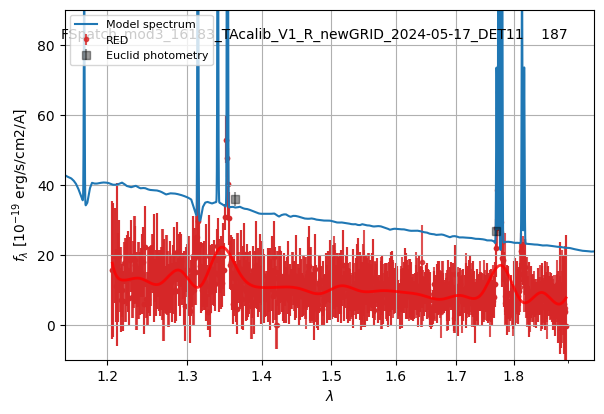

In [61]:
euclid_sims_path = "/Users/gwalth/data/Roman/grizli/sims/Euclid/Raw/EuclidSIMS/"
root = "FSpatch_mod3_16183_TAcalib_V1_R_newGRID_2024-05-17"
frame = 1

id = 187
det_num = '11'
det = 'DET' + det_num

model_spectra_file = euclid_model_spectra_prep(det_num, frame, euclid_sims_path, root)

#fit_redshift_from_id(id, det, HOME_PATH, root) # only needed if missing files
#load_phot_from_id(id, det, HOME_PATH, root)
mb = load_phot_model_from_id(id, det, HOME_PATH, root, model_spectra_file)

In [ ]:
args = np.load("/Users/gwalth/python/src/grizli_v1.6.0.dev42/grizli/tests/data/fit_args.npy", allow_pickle=True)

In [ ]:
print(args[0].keys())
print()
for key in args[0]:
    print(key,args[0][key])

0.8501129
1.2757297
No rescaling, chi-squared=984.8


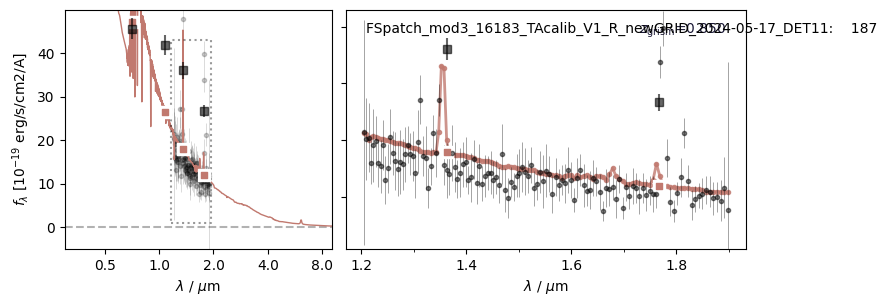

In [72]:
## First example:  no rescaling
z_phot = ez.zbest[ix]
z_spec = ez.cat["z_spec"][ix]
print(z_phot)
print(z_spec)

# Reset scale parameter
if hasattr(mb,'pscale'):
    delattr(mb, 'pscale')
 

tfit = mb.template_at_z(z=z_phot)
#tfit = mb.template_at_z(z=z_spec)

print('No rescaling, chi-squared={0:.1f}'.format(tfit['chi2']))
fig = fitting.full_sed_plot(mb, tfit, zfit=None, bin=4)

[3.5507629]
Simple scaling, chi-squared=755.8


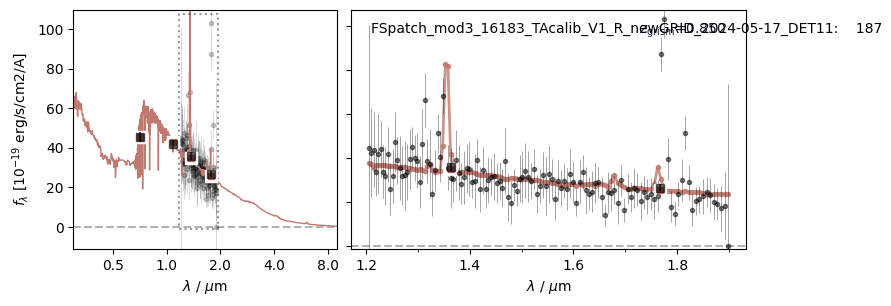

In [73]:
# Reset scale parameter
if hasattr(mb,'pscale'):
    delattr(mb, 'pscale')

# Template rescaling, simple multiplicative factor
scl = mb.scale_to_photometry(order=0)

# has funny units of polynomial coefficients times 10**power, 
# see `grizli.fitting.GroupFitter.compute_scale_array`
# Scale value is the inverse, so, e.g., 
# scl.x = [8.89] means scale the grism spectrum by 10/8.89=1.12
print(scl.x) 

mb.pscale = scl.x 

# Redo template fit
tfit = mb.template_at_z(z=z_phot)
print('Simple scaling, chi-squared={0:.1f}'.format(tfit['chi2']))
fig = fitting.full_sed_plot(mb, tfit, zfit=None, bin=4)

In [74]:
# Reset scale parameter
if hasattr(mb,'pscale'):
    delattr(mb, 'pscale')
    mb.compute_model()

# Template rescaling, linear fit
scl = mb.scale_to_photometry(order=1)

# has funny units of polynomial coefficients times 10**power, 
# see `grizli.fitting.GroupFitter.compute_scale_array`
# Scale value is the inverse, so, e.g., 
# scl.x = [8.89] means scale the grism spectrum by 10/8.89=1.12
print(scl.x) 

mb.pscale = scl.x 

# Redo template fit
tfit = mb.template_at_z(z=z_phot)
print('Simple scaling, chi-squared={0:.1f}'.format(tfit['chi2']))
fig = fitting.full_sed_plot(mb, tfit, zfit=None, bin=4)

ValueError: Method 'lm' doesn't work when the number of residuals is less than the number of variables.

Best redshift: 1.7001


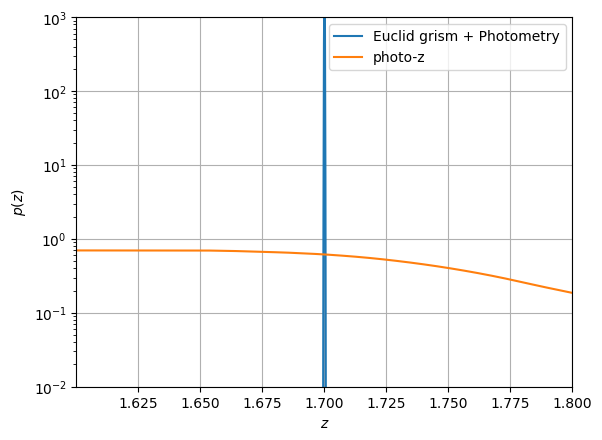

In [78]:
group_name = root + "_" + det
zfit = pyfits.open('{0}_{1:05d}.full.fits'.format(group_name, id))

z_grism = zfit['ZFIT_STACK'].header['Z_MAP']
print('Best redshift: {0:.4f}'.format(z_grism))

# Compare PDFs
pztab = utils.GTable.gread(zfit['ZFIT_STACK'])
plt.plot(pztab['zgrid'], pztab['pdf'], label='Euclid grism + Photometry')

plt.plot(ez.zgrid, np.exp(ez.lnp[ix,:]), label='photo-z')

plt.semilogy()
plt.xlim(z_grism-0.05, z_grism+0.05); plt.ylim(1.e-2, 1000)
plt.xlabel(r'$z$'); plt.ylabel(r'$p(z)$')
plt.grid()
plt.legend()

In [ ]:
# Combine all bands using hstack (test)

import glob, re
L = glob.glob("*.cat")
print(L)


bands = ["VIS", "NISP_Y", "NISP_J", "NISP_H", "total"]
#bands = ["VIS", "NISP_Y", "NISP_J", "NISP_H"]
#bands = ["VIS", "NISP_Y", "NISP_J"]
#ref_band = "NISP_H"

#ref_cat = [l for l in L if l == ref_band][0]
#phot_tbl = Table.read(ref_cat, format="ascii.sextractor")

phot_tbls = []
for band in bands:
    for l in L:
        if band in l: 
            print(l)
            phot_tbl0 = Table.read(l, format="ascii.sextractor")
            phot_tbls.append(phot_tbl0)
            
phot_tbl = hstack(phot_tbls)
print(phot_tbl)
print(phot_tbl.keys())

In [ ]:
import astropy.units as u
from astropy.coordinates import SkyCoord

print(phot_ref_tbl["RA","DEC"])
c = SkyCoord(ra=phot_ref_tbl["RA"], dec=phot_ref_tbl["DEC"])

In [ ]:
idx3, dr3 = phot_ref_tbl["RA","DEC"].match_to_catalog_sky(tab)

In [ ]:
# another test

import glob, re
L = glob.glob("*.cat")
print(L)
L = ["Euclid-NISP_H_ref.cat"]

prefix = "Euclid-"
suffix = "_ref.cat"

for l in L: 
    #print(l)
    
    i0 = re.search(prefix,l).end()
    i1 = re.search(suffix,l).start()
    
    #print(i0,i1)
    band = l[i0:i1]
    print(band)
    
    phot_tbl = Table.read(l, format="ascii.sextractor")

    print(phot_tbl.keys())
    for key in phot_tbl.keys():
        #print(key.split("_"))
        if key.split("_")[0].lower() in ["flux", "fluxerr", "flag", "bkg", "mask"]:
            print(key)
        #if "FLUX" in key: print(key)
    #    if "MAG" in key: print(key)

In [ ]:
#test_path = "/Users/gwalth/data/Roman/grizli/sims/hlss/Prep/"
#phot_tbl = Table.read(test_path + 'hlss-ir.cat.fits', format="fits")
#phot_tbl = Table.read(test_path + 'hlss_phot.fits', format="fits")
#phot_tbl = Table.read(test_path + 'hlss-F158.cat.fits', format="fits")


test_path = "/Users/gwalth/data/HST/grizli/CUBS/j233932m5519/Prep/"
phot_tbl = Table.read(test_path + 'j233932m5519-ir.cat.fits', format="fits")
print(phot_tbl.keys())
print()
phot_tbl = Table.read(test_path + 'j233932m5519_phot.fits', format="fits")
print(phot_tbl.keys())

In [ ]:
# flux, fluxerr, flag, bkg, mask

#    for c in tab.colnames:
#        tab.rename_column(c, c.lower())


# changes number to id
# at the end adds tot_corr

In [ ]:
#import glob
#L = glob.glob("*.cat")
#print(L)

phot_tbl = Table.read('Euclid-NISP_Y_ref.cat', format="ascii.sextractor")

In [ ]:
print(phot_tbl)
print(phot_tbl.keys())